In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

## Features

1 (Taken)

In [8]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':')
    res_list = []

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') 
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) 
        res_list.append(np.nansum(df_rel['gte_50runs']))
        
    return np.nansum(res_list)

In [9]:
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

train_data = train_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

100%|██████████| 271/271 [00:04<00:00, 55.22it/s]


slope: 0.6 / 0.39 =  1.53


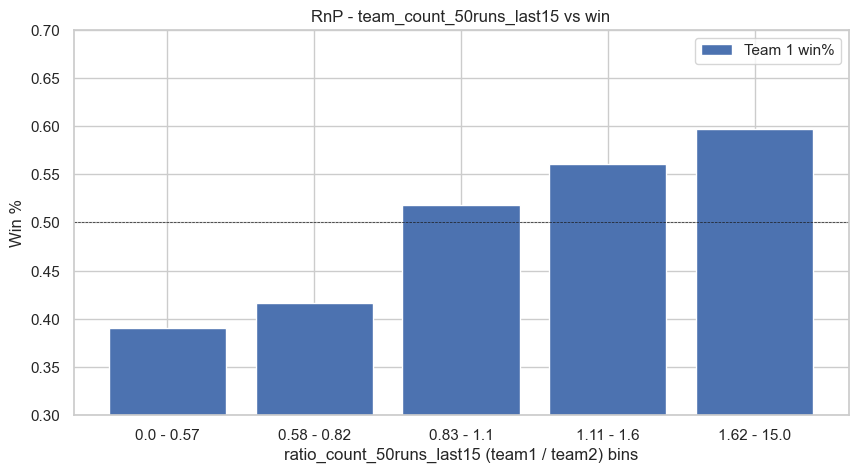

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931


In [10]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


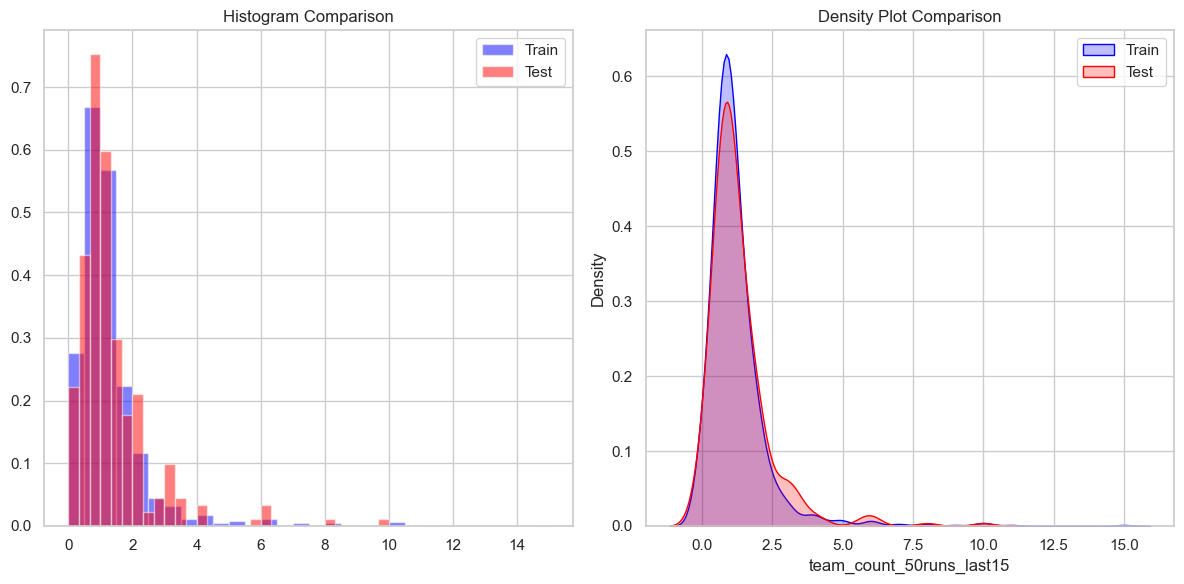

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000


In [11]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

2 (Taken)

In [12]:
def match_impact_score(player_list, date, n):
    player_list = player_list.split(':')
    total_impact_score = 0
    count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            avg_runs = player_matches['runs'].mean()
            avg_strike_rate = player_matches['strike_rate'].mean()
            top_scorer_count = sum(player_matches['runs'] == player_matches.groupby('match id')['runs'].transform('max'))

            impact_score = (avg_runs * avg_strike_rate * top_scorer_count) / 100
            total_impact_score += impact_score
            count += 1

    return total_impact_score / count if count > 0 else 0

In [13]:
train_data['team1_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

train_data = train_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

test_data['team1_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

test_data = test_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

100%|██████████| 271/271 [00:05<00:00, 52.25it/s]


slope: 0.64 / 0.36 =  1.78


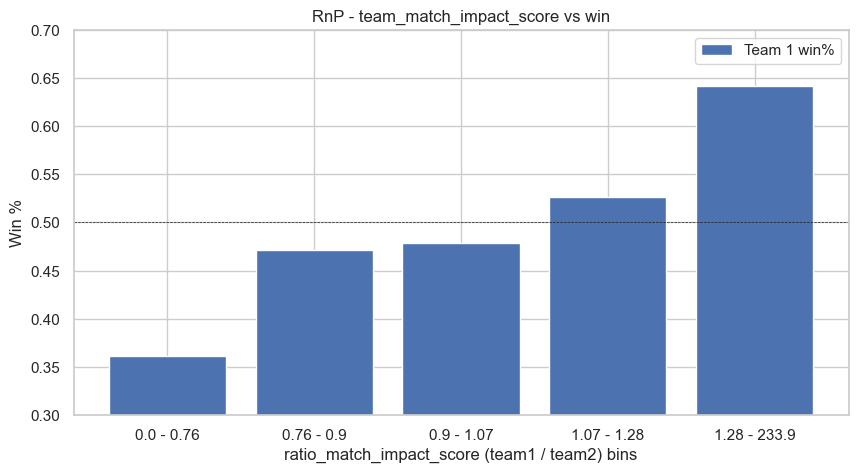

Correlation between team_match_impact_score and winner_01 is: -0.059264563222164945


In [14]:
createRnP(train_data, 'team_match_impact_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


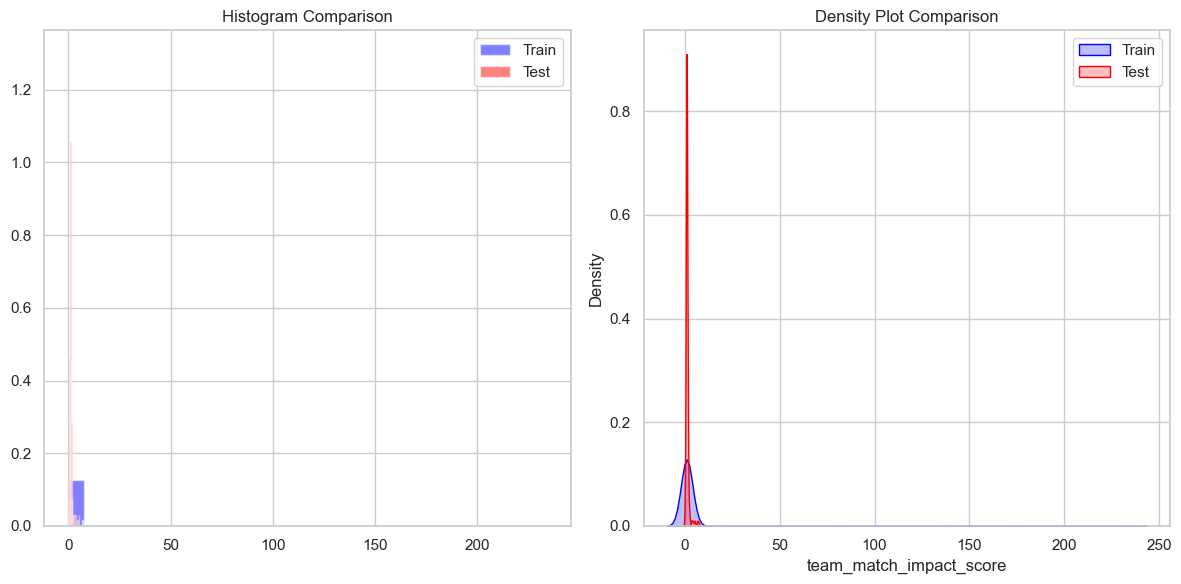

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   945.000000  270.000000
mean      2.036078    1.163776
std      11.900496    0.883064
min       0.000000    0.000000
25%       0.790835    0.811949
50%       0.989617    0.987300
75%       1.217684    1.230643
max     233.897878    7.362204


In [15]:
check_distribution_match(train_data['team_match_impact_score'], test_data['team_match_impact_score'])

3.

In [16]:
def average_runs_per_match(player_list, date, n):
    """
    Calculates the mean runs scored per match for a list of players over the last n matches before a given date.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Mean runs per match for the list of players
    """
    player_list = player_list.split(':')
    total_runs = 0
    games_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            total_runs += player_matches['runs'].sum()
            games_count += len(player_matches)

    return total_runs / games_count if games_count > 0 else 0

In [17]:
train_data['team1_average_runs_per_match'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_average_runs_per_match'] = train_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_runs_per_match', 'team2_average_runs_per_match', 'team_average_runs_per_match')

train_data = train_data.drop(columns=['team1_average_runs_per_match', 'team2_average_runs_per_match'])

test_data['team1_average_runs_per_match'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_average_runs_per_match'] = test_data.progress_apply(lambda x: \
            average_runs_per_match(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_runs_per_match', 'team2_average_runs_per_match', 'team_average_runs_per_match')

test_data = test_data.drop(columns=['team1_average_runs_per_match', 'team2_average_runs_per_match'])

100%|██████████| 271/271 [00:04<00:00, 62.39it/s]


slope: 0.55 / 0.46 =  1.19


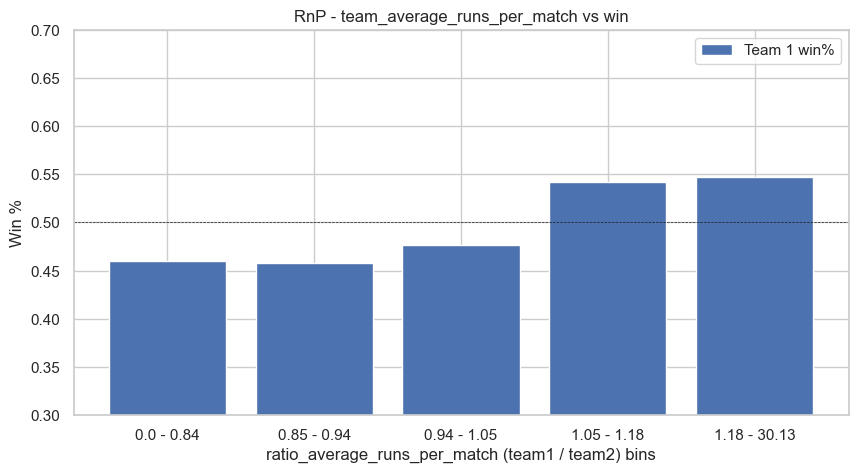

Correlation between team_average_runs_per_match and winner_01 is: -0.05775475033119512


In [18]:
createRnP(train_data, 'team_average_runs_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


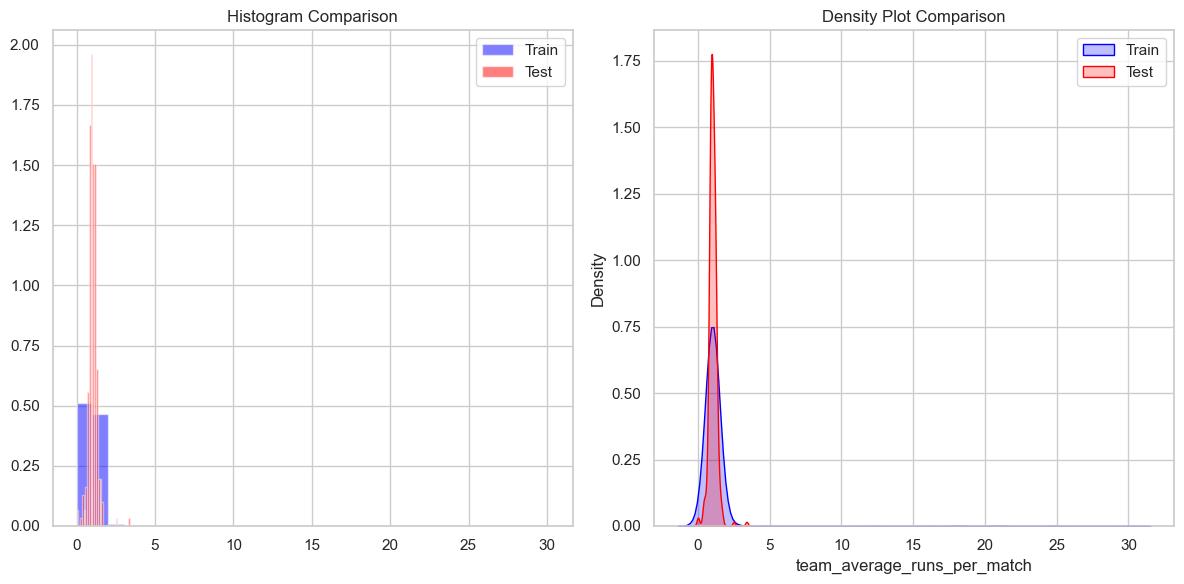

Kolmogorov-Smirnov test result: KS statistic = 0.0426, p-value = 0.8202

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.175370    1.021009
std       1.836720    0.288018
min       0.000000    0.000000
25%       0.868826    0.875353
50%       0.999033    1.008384
75%       1.142212    1.166202
max      30.133333    3.386364


In [19]:
check_distribution_match(train_data['team_average_runs_per_match'], test_data['team_average_runs_per_match'])

4. (Taken)

In [20]:
def balls_efficiency_score(player_list, date, n):
    """
    Evaluates the mean efficiency of scoring runs based on the number of balls faced for a list of players.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Mean efficiency score (total runs divided by total balls faced) for the list of players
    """
    player_list = player_list.split(':')
    total_runs = 0
    total_balls = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            total_runs += player_matches['runs'].sum()
            total_balls += player_matches['balls_faced'].sum()

    return total_runs / total_balls if total_balls > 0 else 0

In [21]:
train_data['team1_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

train_data = train_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

test_data['team1_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

test_data = test_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

100%|██████████| 271/271 [00:04<00:00, 61.99it/s]


slope: 0.62 / 0.39 =  1.59


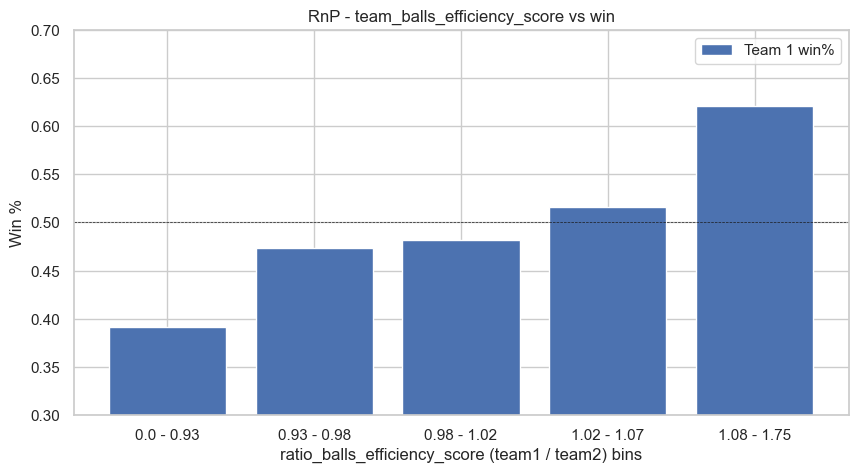

Correlation between team_balls_efficiency_score and winner_01 is: -0.15330782131214032


In [22]:
createRnP(train_data, 'team_balls_efficiency_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


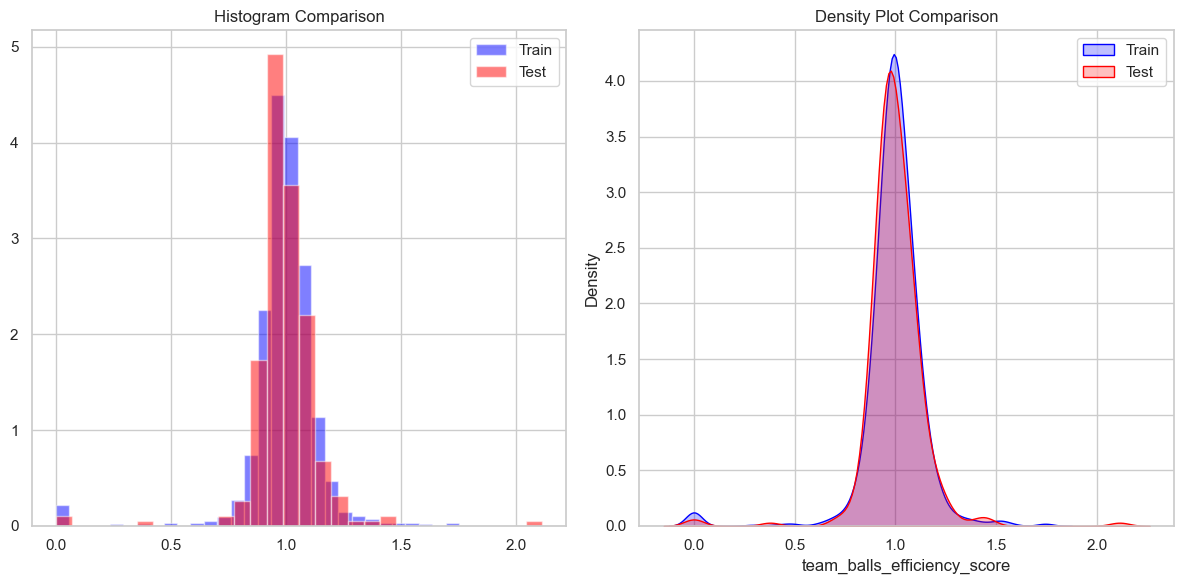

Kolmogorov-Smirnov test result: KS statistic = 0.1000, p-value = 0.0271

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.993906    0.996573
std       0.162549    0.153018
min       0.000000    0.000000
25%       0.943062    0.939211
50%       0.998334    0.981431
75%       1.058843    1.054250
max       1.752989    2.112944


In [23]:
check_distribution_match(train_data['team_balls_efficiency_score'], test_data['team_balls_efficiency_score'])

5.

In [24]:
def early_impact_score(player_list, date, n, early_overs=5):
    """
    Calculates the mean early impact score based on runs scored in the initial overs for a list of players.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :param early_overs: Number of initial overs to consider for calculating the impact
    :return: Mean early impact score for the list of players
    """
    player_list = player_list.split(':')
    total_early_runs = 0
    early_games_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        early_matches = player_matches[player_matches['over_faced_first'] <= early_overs]
        if not early_matches.empty:
            total_early_runs += early_matches['runs'].sum()
            early_games_count += len(early_matches)

    return total_early_runs / early_games_count if early_games_count > 0 else 0

In [25]:
train_data['team1_early_impact_score'] = train_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_early_impact_score'] = train_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_early_impact_score', 'team2_early_impact_score', 'team_early_impact_score')

train_data = train_data.drop(columns=['team1_early_impact_score', 'team2_early_impact_score'])

test_data['team1_early_impact_score'] = test_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_early_impact_score'] = test_data.progress_apply(lambda x: \
            early_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_early_impact_score', 'team2_early_impact_score', 'team_early_impact_score')

test_data = test_data.drop(columns=['team1_early_impact_score', 'team2_early_impact_score'])

100%|██████████| 271/271 [00:04<00:00, 58.41it/s]


slope: 0.53 / 0.41 =  1.29


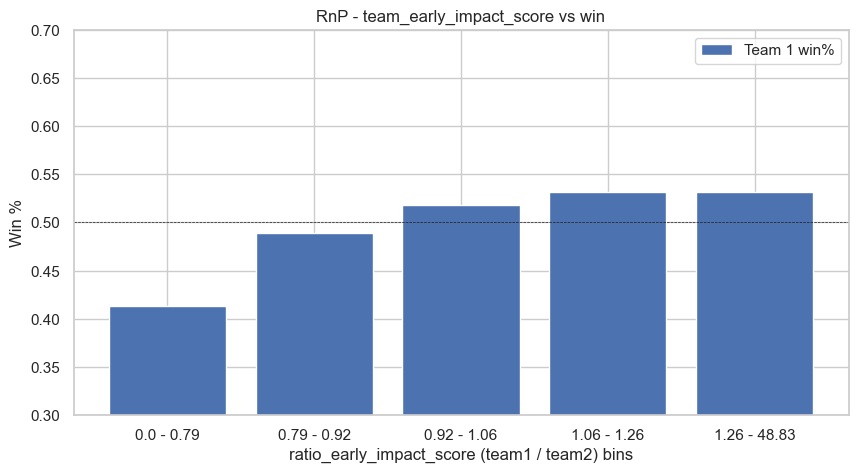

Correlation between team_early_impact_score and winner_01 is: -0.004679077475574761


In [26]:
createRnP(train_data, 'team_early_impact_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


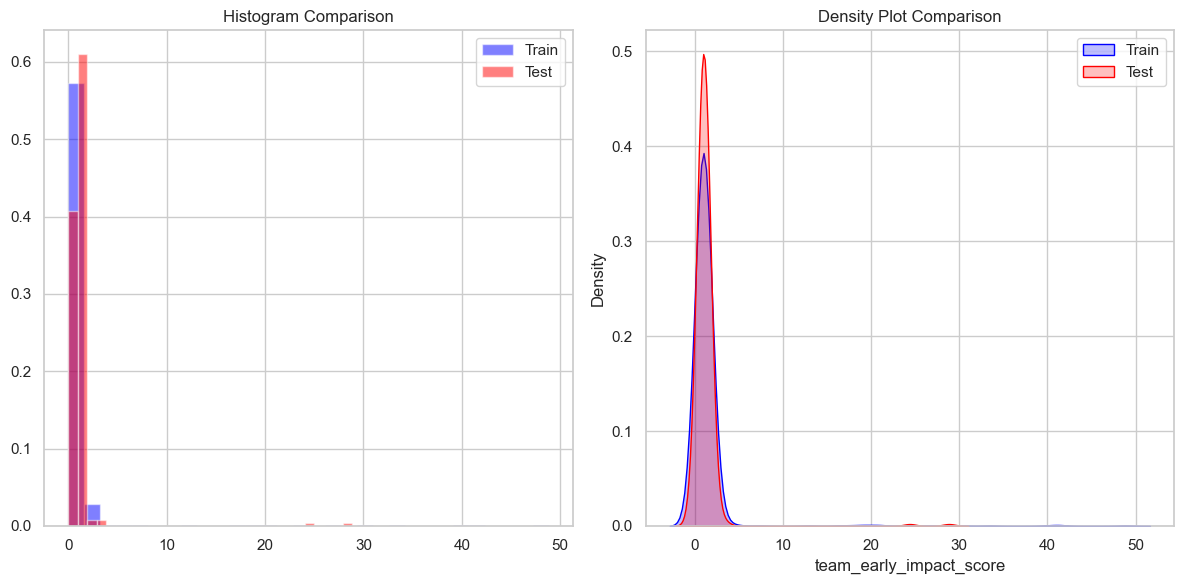

Kolmogorov-Smirnov test result: KS statistic = 0.0846, p-value = 0.0920

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.485022    1.235742
std       3.682111    2.233260
min       0.000000    0.000000
25%       0.830783    0.851305
50%       0.987384    1.023445
75%       1.210242    1.207323
max      48.833333   28.846154


In [27]:
check_distribution_match(train_data['team_early_impact_score'], test_data['team_early_impact_score'])

6.

In [28]:
def boundary_efficiency_score(player_list, date, n):
    """
    Measures the team's efficiency in scoring from boundaries (fours) relative to the total runs scored.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Boundary efficiency score as a percentage
    """
    player_list = player_list.split(':')
    total_runs = 0
    runs_from_fours = 0
    runs_from_sixes = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        total_runs += player_matches['runs'].sum()
        runs_from_fours += player_matches['Fours'].sum() * 4
        runs_from_sixes += player_matches['Sixes'].sum() * 6

    return (runs_from_fours+runs_from_sixes / total_runs) * 100 if total_runs > 0 else 0

In [29]:
train_data['team1_boundary_efficiency_score'] = train_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_boundary_efficiency_score'] = train_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_boundary_efficiency_score', 'team2_boundary_efficiency_score', 'team_boundary_efficiency_score')

train_data = train_data.drop(columns=['team1_boundary_efficiency_score', 'team2_boundary_efficiency_score'])

test_data['team1_boundary_efficiency_score'] = test_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_boundary_efficiency_score'] = test_data.progress_apply(lambda x: \
            boundary_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_boundary_efficiency_score', 'team2_boundary_efficiency_score', 'team_boundary_efficiency_score')

test_data = test_data.drop(columns=['team1_boundary_efficiency_score', 'team2_boundary_efficiency_score'])

100%|██████████| 271/271 [00:04<00:00, 60.24it/s]


slope: 0.62 / 0.37 =  1.66


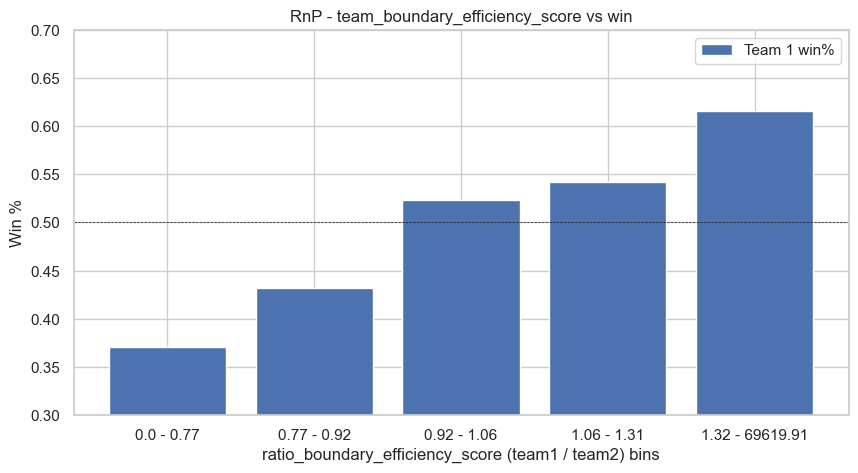

Correlation between team_boundary_efficiency_score and winner_01 is: -0.05020967518231


In [30]:
createRnP(train_data, 'team_boundary_efficiency_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


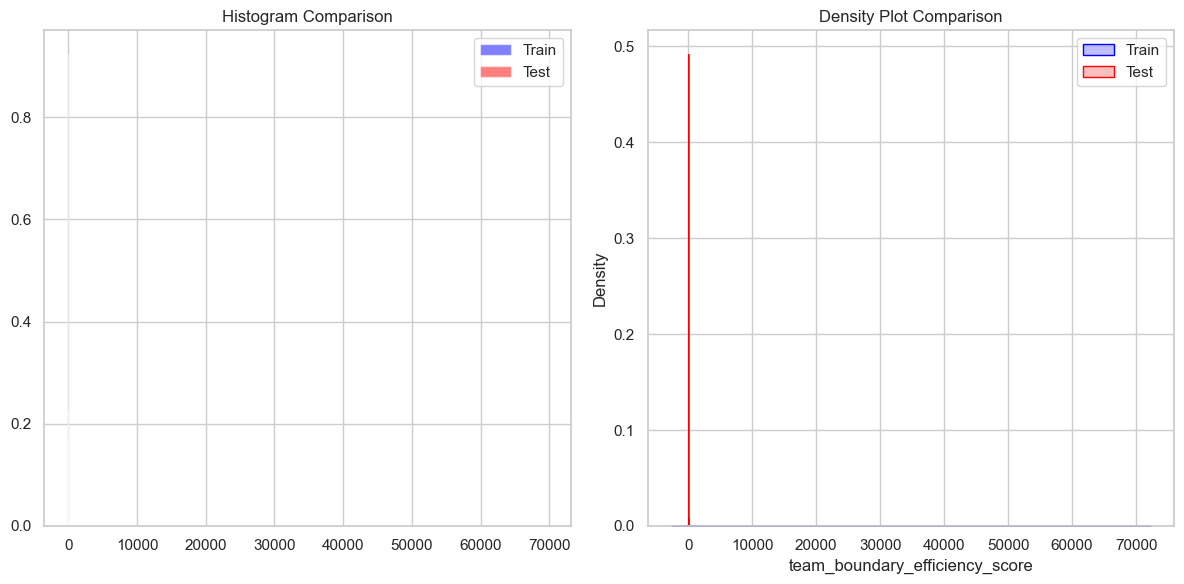

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5423

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean     249.973580    1.362262
std     3371.025234    2.076779
min        0.000000    0.000000
25%        0.814000    0.806361
50%        0.981386    0.995360
75%        1.232128    1.273554
max    69619.906687   21.459506


In [31]:
check_distribution_match(train_data['team_boundary_efficiency_score'], test_data['team_boundary_efficiency_score'])

7.

In [32]:
def team_average_powerplay_score(player_list, date, n):
    """
    Calculates the team's average runs during the powerplay overs.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Average powerplay runs
    """
    player_list = player_list.split(':')
    total_powerplay_runs = 0
    powerplay_innings_count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        powerplay_matches = player_matches[player_matches['over_faced_first'] <= 6]  # Considering 6 overs for T20
        total_powerplay_runs += powerplay_matches['runs'].sum()
        powerplay_innings_count += len(powerplay_matches)

    return total_powerplay_runs / powerplay_innings_count if powerplay_innings_count > 0 else 0

In [33]:
train_data['team1_team_average_powerplay_score'] = train_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_average_powerplay_score'] = train_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_average_powerplay_score', 'team2_team_average_powerplay_score', 'team_team_average_powerplay_score')

train_data = train_data.drop(columns=['team1_team_average_powerplay_score', 'team2_team_average_powerplay_score'])

test_data['team1_team_average_powerplay_score'] = test_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_average_powerplay_score'] = test_data.progress_apply(lambda x: \
            team_average_powerplay_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_average_powerplay_score', 'team2_team_average_powerplay_score', 'team_team_average_powerplay_score')

test_data = test_data.drop(columns=['team1_team_average_powerplay_score', 'team2_team_average_powerplay_score'])

100%|██████████| 271/271 [00:04<00:00, 57.82it/s]


slope: 0.55 / 0.4 =  1.36


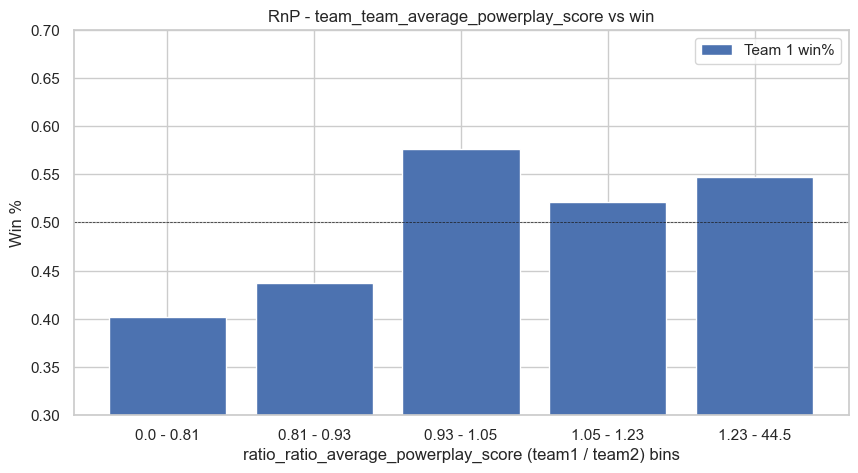

Correlation between team_team_average_powerplay_score and winner_01 is: -0.035243350866783534


In [34]:
createRnP(train_data, 'team_team_average_powerplay_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


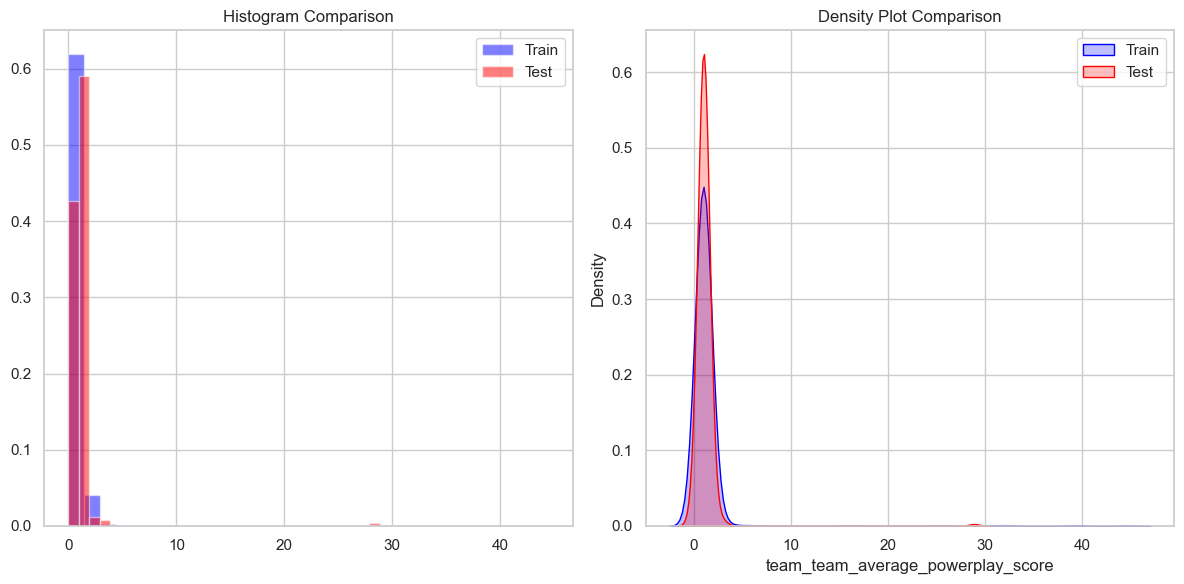

Kolmogorov-Smirnov test result: KS statistic = 0.0598, p-value = 0.4197

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.370185    1.140202
std       3.220418    1.726201
min       0.000000    0.000000
25%       0.839541    0.867860
50%       0.992005    1.011010
75%       1.182197    1.162726
max      44.500000   28.846154


In [35]:
check_distribution_match(train_data['team_team_average_powerplay_score'], test_data['team_team_average_powerplay_score'])

8. 

In [36]:
def team_scoring_consistency(player_list, date, n):
    """
    Calculates the standard deviation of runs scored by the team, indicating scoring consistency.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider for each player
    :return: Standard deviation of team scores
    """
    player_list = player_list.split(':')
    scores = []

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        scores.extend(player_matches['runs'].tolist())

    return np.std(scores) if scores else 0

In [37]:
train_data['team1_team_scoring_consistency'] = train_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_team_scoring_consistency'] = train_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_team_scoring_consistency', 'team2_team_scoring_consistency', 'team_team_scoring_consistency')

train_data = train_data.drop(columns=['team1_team_scoring_consistency', 'team2_team_scoring_consistency'])

test_data['team1_team_scoring_consistency'] = test_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_team_scoring_consistency'] = test_data.progress_apply(lambda x: \
            team_scoring_consistency(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_team_scoring_consistency', 'team2_team_scoring_consistency', 'team_team_scoring_consistency')

test_data = test_data.drop(columns=['team1_team_scoring_consistency', 'team2_team_scoring_consistency'])

100%|██████████| 271/271 [00:04<00:00, 61.82it/s]


slope: 0.55 / 0.43 =  1.29


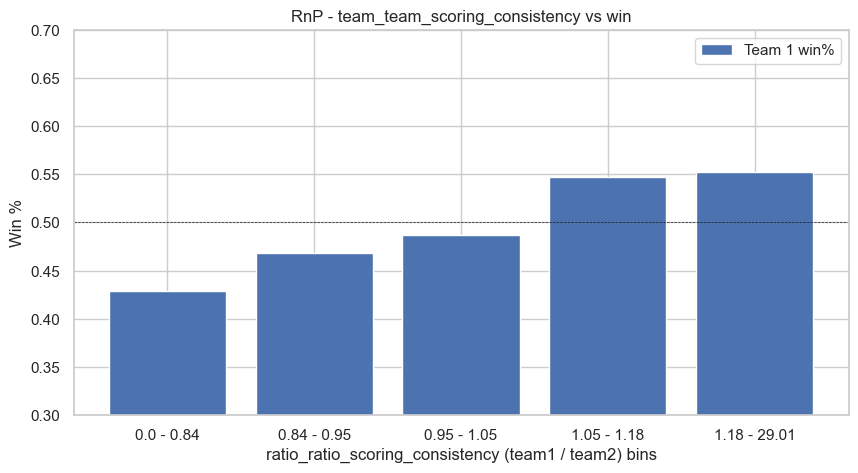

Correlation between team_team_scoring_consistency and winner_01 is: -0.033233741391659126


In [38]:
createRnP(train_data, 'team_team_scoring_consistency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


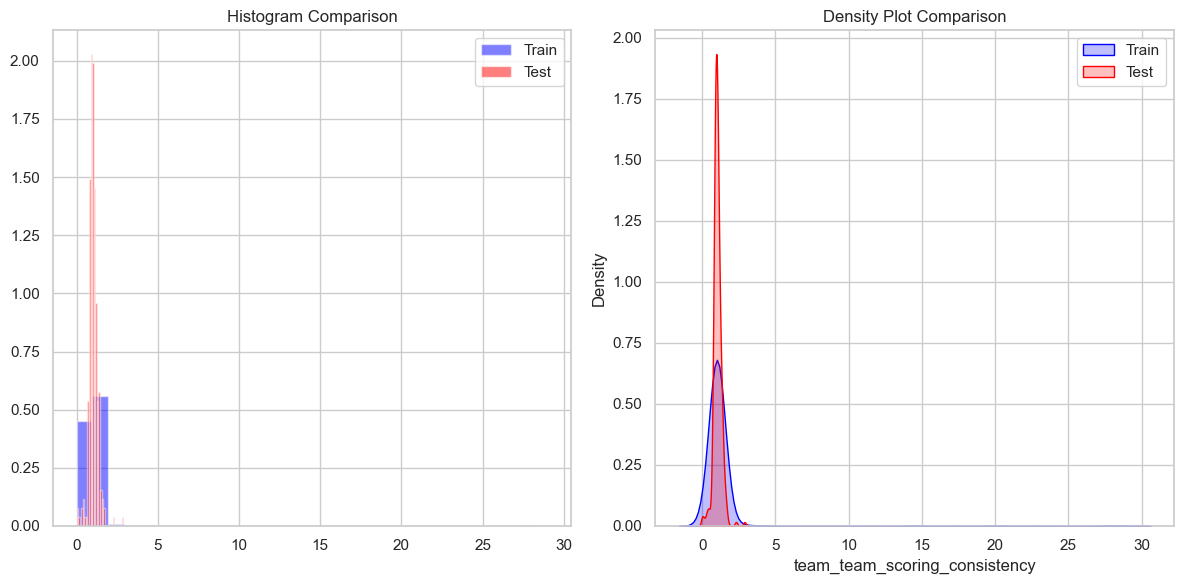

Kolmogorov-Smirnov test result: KS statistic = 0.0359, p-value = 0.9374

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.210957    1.018603
std       2.082633    0.277409
min       0.000000    0.000000
25%       0.879305    0.876245
50%       1.001085    0.993741
75%       1.136666    1.136663
max      29.012335    2.891366


In [39]:
check_distribution_match(train_data['team_team_scoring_consistency'], test_data['team_team_scoring_consistency'])

## Bowler

1. (Taken)

In [40]:
num_matches = 15

In [41]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

In [42]:
train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

slope: 0.58 / 0.38 =  1.56


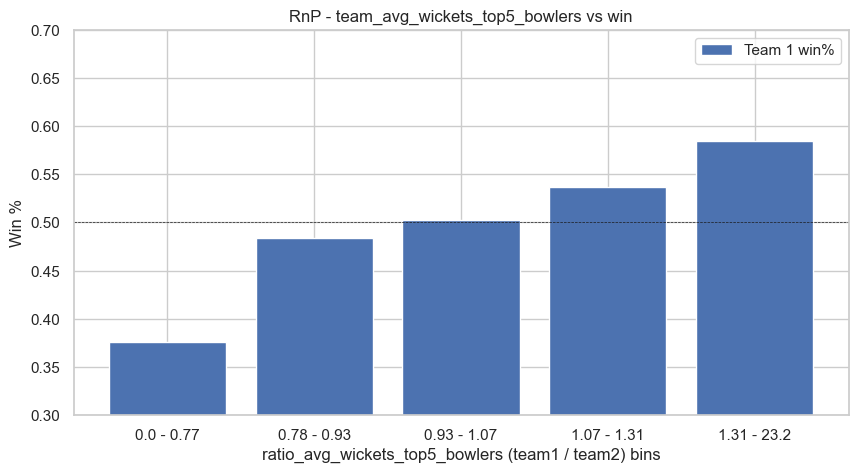

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.12496003337472769


In [43]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


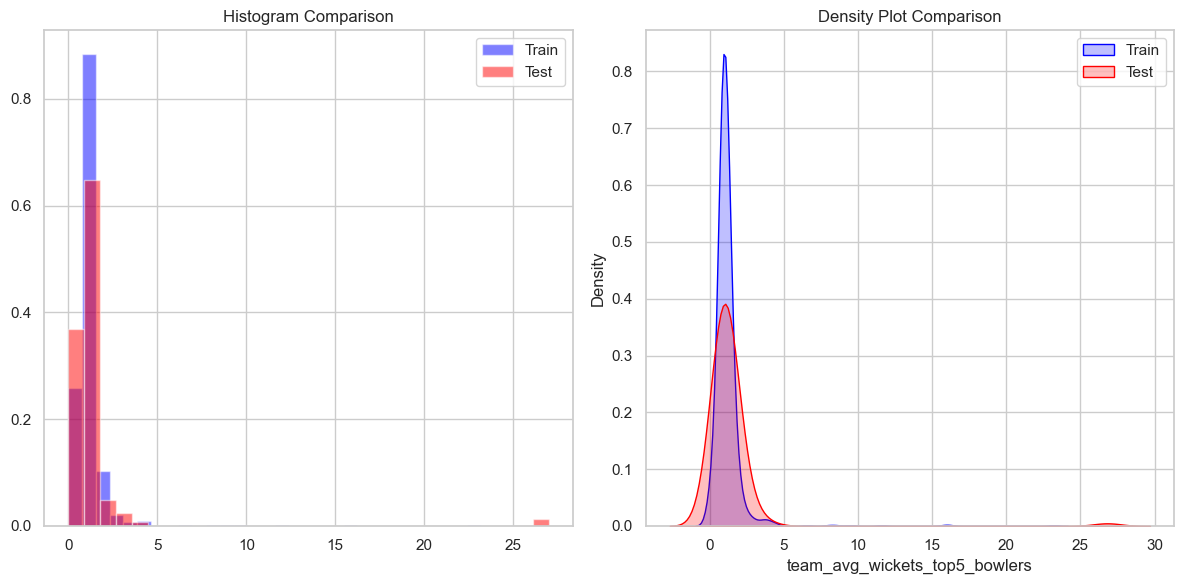

Kolmogorov-Smirnov test result: KS statistic = 0.0509, p-value = 0.6235

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.172481    1.395288
std       1.267244    2.751009
min       0.000000    0.000000
25%       0.822644    0.825778
50%       1.000000    1.025974
75%       1.233242    1.249694
max      23.200000   27.000000


In [44]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

2 (Taken)

In [45]:
def extra_runs_conceded(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_extras = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()

    return total_extras

In [46]:
train_data['team1_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

train_data = train_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

test_data['team1_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

test_data = test_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

slope: 0.53 / 0.44 =  1.2


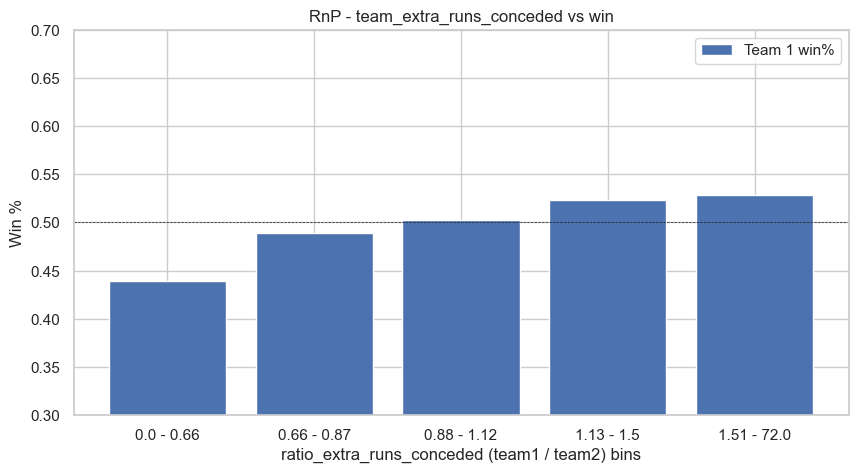

Correlation between team_extra_runs_conceded and winner_01 is: -0.07484662505475996


In [47]:
createRnP(train_data, 'team_extra_runs_conceded')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


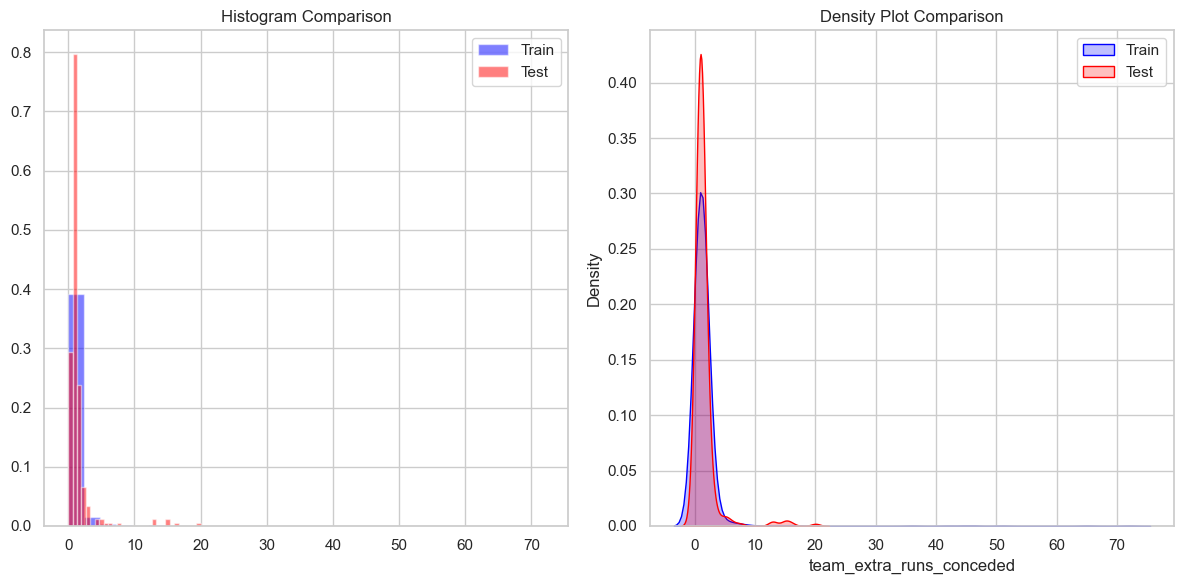

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8553

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.590927    1.484492
std       4.566753    2.297023
min       0.000000    0.000000
25%       0.719245    0.717724
50%       1.000000    0.965517
75%       1.397619    1.361063
max      72.000000   20.000000


In [48]:
check_distribution_match(train_data['team_extra_runs_conceded'], test_data['team_extra_runs_conceded'])

4 (Taken)

In [49]:
def average_dots_per_match(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_dots = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_dots += recent_matches['dots'].sum()
        total_matches += len(recent_matches)

    return total_dots / total_matches if total_matches > 0 else 0


In [50]:
train_data['team1_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

train_data = train_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

test_data['team1_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

test_data = test_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

slope: 0.55 / 0.42 =  1.29


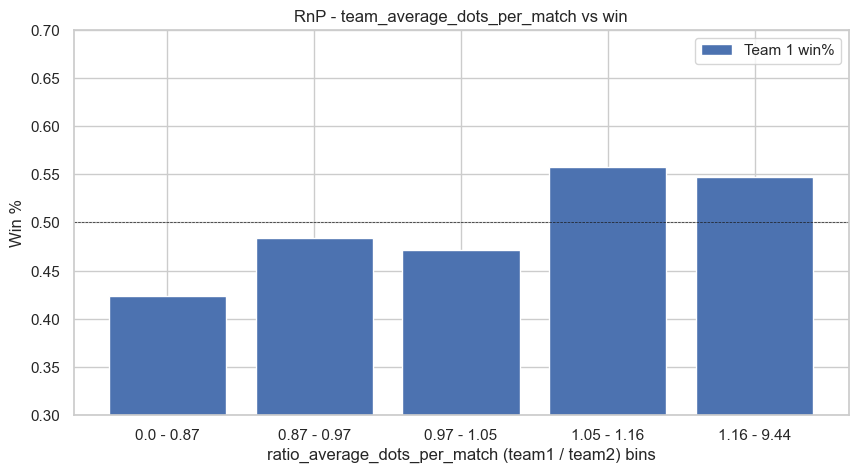

Correlation between team_average_dots_per_match and winner_01 is: -0.06897569738223483


In [51]:
createRnP(train_data, 'team_average_dots_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


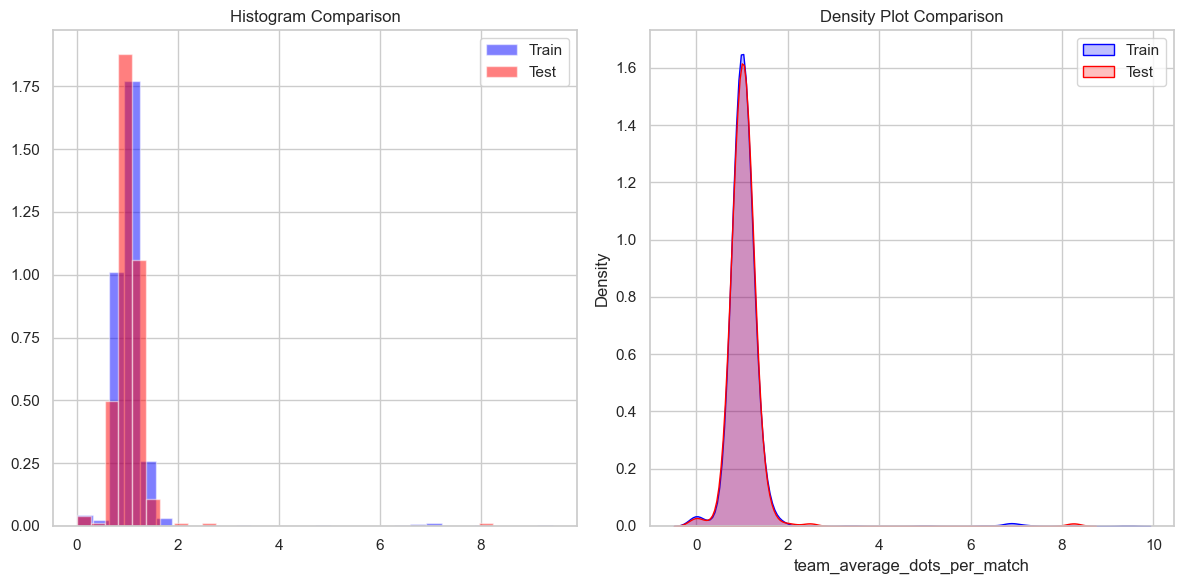

Kolmogorov-Smirnov test result: KS statistic = 0.0516, p-value = 0.6059

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.072134    1.042975
std       0.644385    0.499809
min       0.000000    0.000000
25%       0.892069    0.885041
50%       1.008887    1.019371
75%       1.124893    1.135280
max       9.437500    8.250000


In [52]:
check_distribution_match(train_data['team_average_dots_per_match'], test_data['team_average_dots_per_match'])

Continue......

## New2

1. (Consider)

In [53]:
def team_wicket_loss_average(team_id, date, match_lvl_data):
    team_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ]
    team_wickets = team_matches.apply(
        lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1
    )
    return team_wickets.mean() if len(team_wickets) > 0 else 0

In [54]:
train_data['team1_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

train_data = train_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

test_data['team1_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

test_data = test_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

slope: 0.53 / 0.47 =  1.14


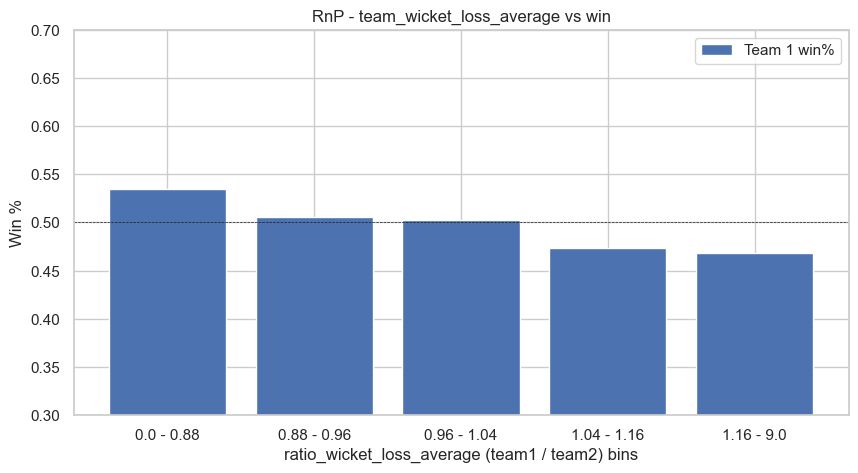

Correlation between team_wicket_loss_average and winner_01 is: -0.012728204099509413


In [55]:
createRnP(train_data, 'team_wicket_loss_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


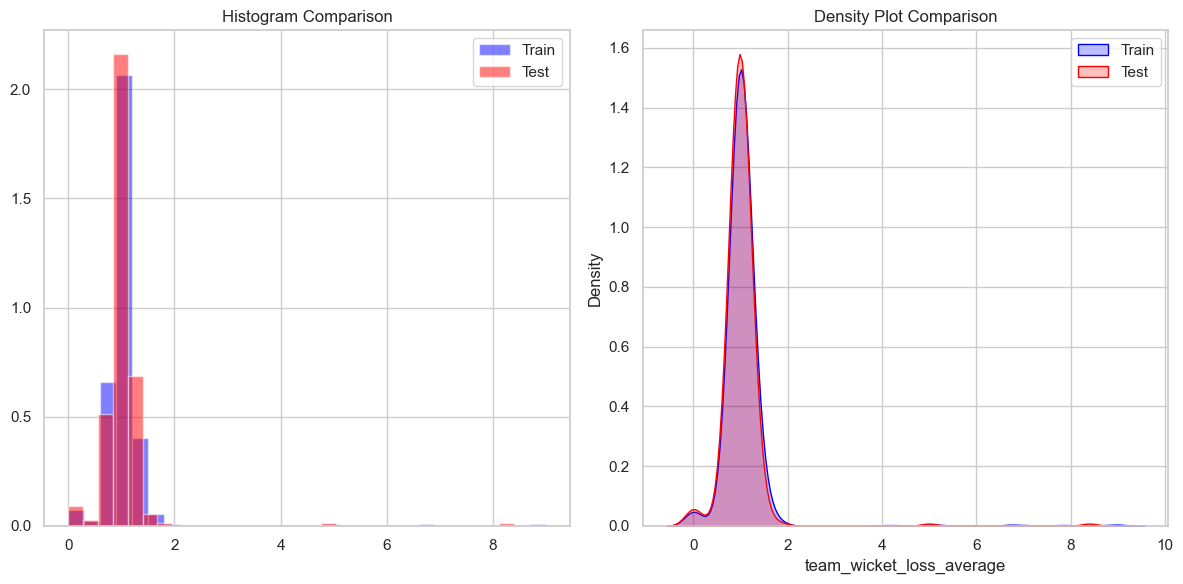

Kolmogorov-Smirnov test result: KS statistic = 0.1095, p-value = 0.0115

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.085126    1.012449
std       0.743221    0.563005
min       0.000000    0.000000
25%       0.909314    0.877306
50%       1.008309    0.985822
75%       1.122680    1.095405
max       9.000000    8.400000


In [56]:
check_distribution_match(train_data['team_wicket_loss_average'], test_data['team_wicket_loss_average'])

2. (Taken)

In [57]:
#new feature 1 bowler's performance of teams in recent mathes
def team_bowler_performance_recent(bowler_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count']) * 5 + recent_matches['dots']*1.5+(recent_matches['maiden']) * 1.5 -(recent_matches['Fours'] * 1) - recent_matches['Sixes']*1.5 - recent_matches['wides'] - recent_matches['noballs']                            
            total_impact_score += player_impact.sum()

    return total_impact_score

In [58]:
train_data['team1_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
train_data = add_ratio_column(train_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

test_data['team1_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
test_data = add_ratio_column(test_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

slope: 0.61 / 0.34 =  1.8


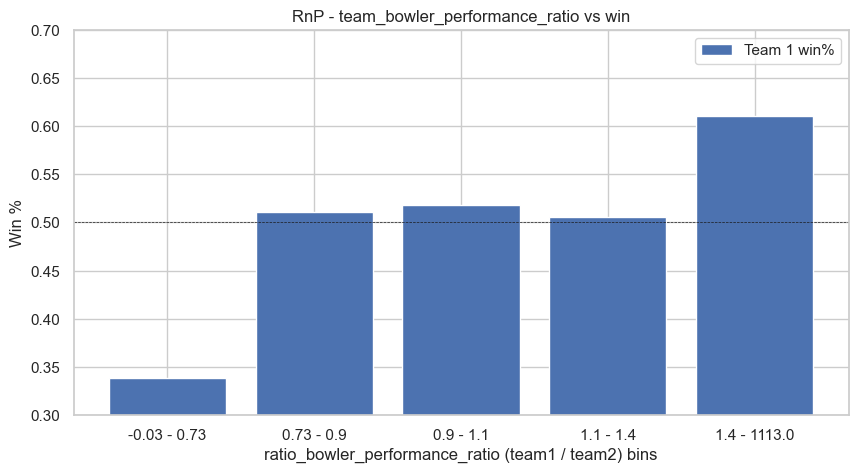

Correlation between team_bowler_performance_ratio and winner_01 is: -0.05037630480130837


In [59]:
createRnP(train_data, 'team_bowler_performance_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


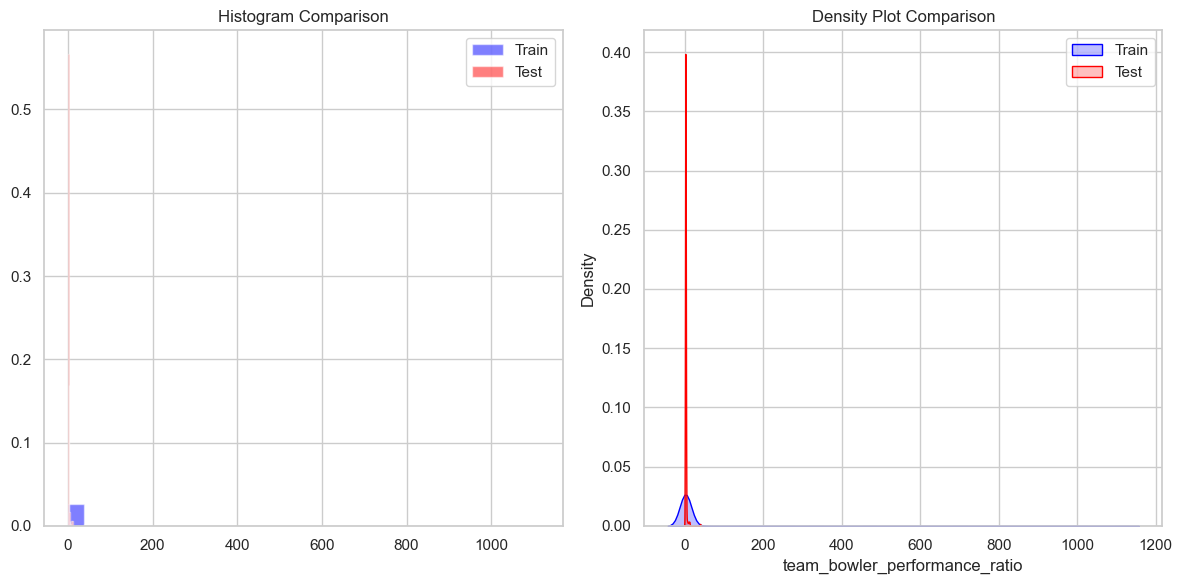

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.618912    1.420354
std      57.700298    2.597474
min      -0.028103    0.000000
25%       0.790858    0.826576
50%       0.981911    1.051232
75%       1.284090    1.334909
max    1113.000000   38.500000


In [60]:
check_distribution_match(train_data['team_bowler_performance_ratio'], test_data['team_bowler_performance_ratio'])

3. (Taken)

In [61]:
def average_wickets_taken(player_list, date, n):
    player_list = player_list.split(':')
    wickets_list = []
    for player_id in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_wickets = recent_matches['wicket_count'].sum()
        average_wickets = total_wickets / n if n > 0 else 0
        wickets_list.append(average_wickets)
    return sum(wickets_list) / len(wickets_list) if wickets_list else 0

In [62]:
train_data['team1_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

train_data = train_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

test_data['team1_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

test_data = test_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

100%|██████████| 271/271 [00:03<00:00, 77.91it/s]


slope: 0.6 / 0.39 =  1.55


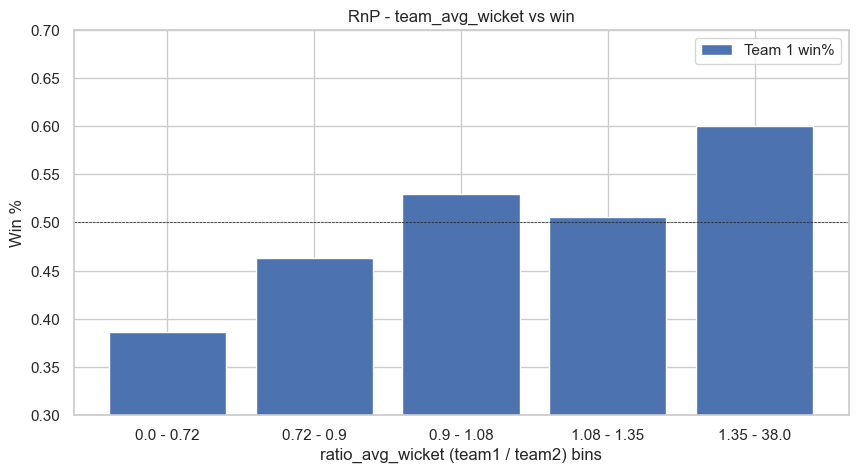

Correlation between team_avg_wicket and winner_01 is: -0.10351532938769395


In [63]:
createRnP(train_data, 'team_avg_wicket')

4. (Taken)

In [64]:
def team_batting_strength(player_list, date, n):
    players = player_list.split(':')
    total_runs = 0
    for player_id in players:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        total_runs += recent_matches['runs'].sum()
    return total_runs / len(players) if players else 0

In [65]:
train_data['team1_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

train_data = train_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

test_data['team1_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

test_data = test_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

100%|██████████| 271/271 [00:04<00:00, 61.76it/s]


slope: 0.64 / 0.34 =  1.88


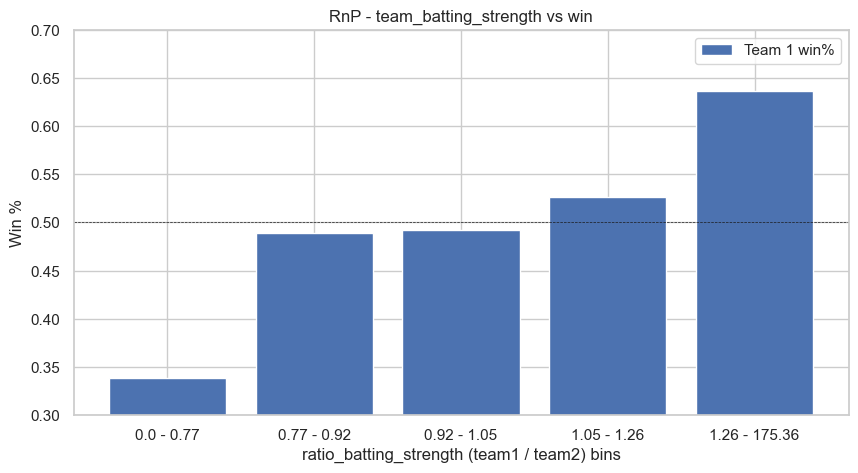

Correlation between team_batting_strength and winner_01 is: -0.06285430528267014


In [66]:
createRnP(train_data, 'team_batting_strength')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


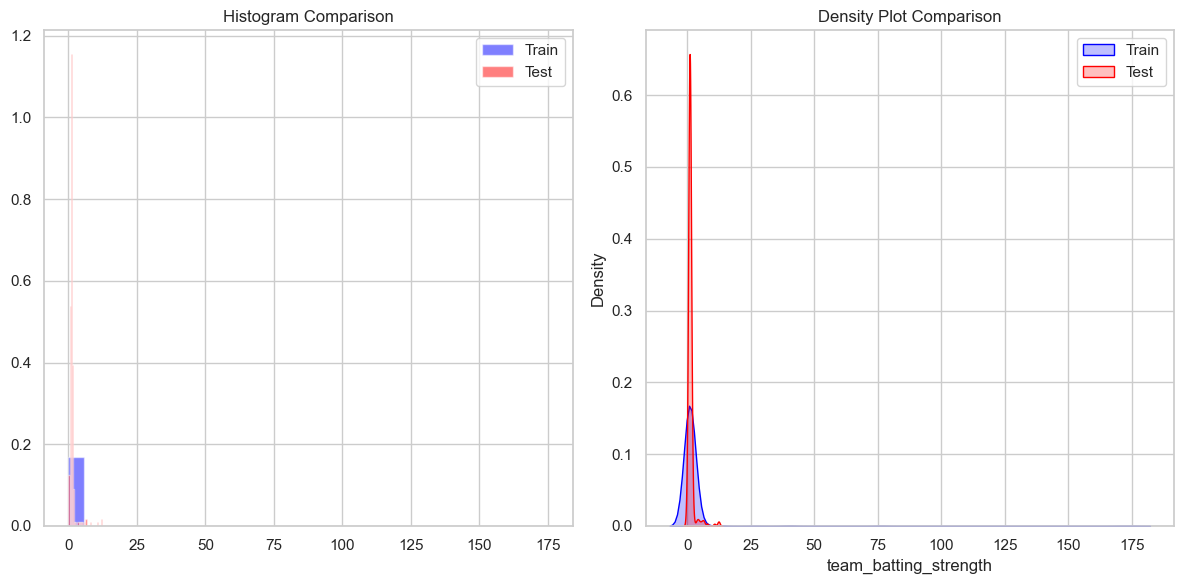

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.791761    1.270211
std       8.971790    1.436063
min       0.000000    0.000000
25%       0.813151    0.815097
50%       0.978937    0.993631
75%       1.189842    1.239880
max     175.363636   12.362069


In [67]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

6.

In [68]:
def team_win_rate_at_venue(team_id, venue_id, date, match_lvl_data):
    # Filter matches where the team played at the given venue up to the specified date
    relevant_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                      ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['match_dt'] < date)]
    wins = relevant_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    win_rate = wins / len(relevant_matches) if len(relevant_matches) > 0 else 0
    return win_rate

In [69]:
train_data['team1_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

test_data['team1_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.2


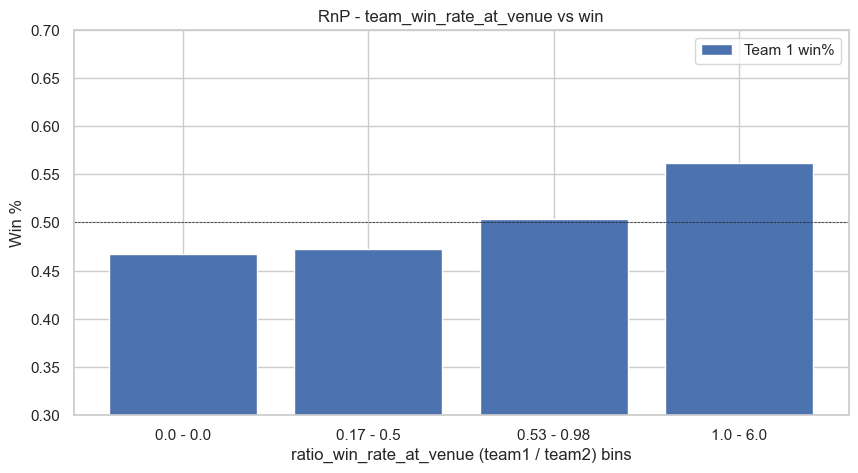

Correlation between team_win_rate_at_venue and winner_01 is: -0.053605345112640965


In [70]:
createRnP(train_data, 'team_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


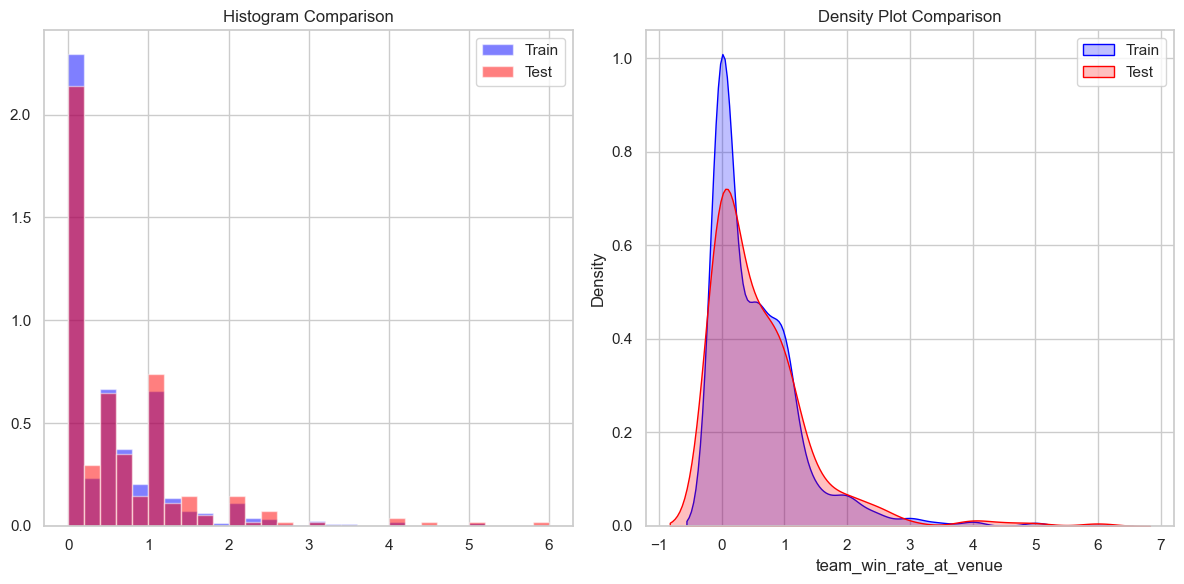

Kolmogorov-Smirnov test result: KS statistic = 0.0447, p-value = 0.7729

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542736    0.610468
std       0.740733    0.848285
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.930804    1.000000
max       6.000000    6.000000


In [71]:
check_distribution_match(train_data['team_win_rate_at_venue'], test_data['team_win_rate_at_venue'])

8.

In [72]:
def team_batsman_performance_index(bat_df, match_id, team_roster_ids, date, n=5):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 0.5 +
                                  recent_matches['strike_rate'] * 0.3 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] * 2) * 0.2) * \
                                  (1 + 0.1 * recent_matches['is_batsman_captain'].iloc[0] +
                                   0.05 * recent_matches['is_batsman_keeper'].iloc[0])
            total_performance_index += player_performance.sum()

    return total_performance_index

In [73]:
train_data['team1_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

train_data = train_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

test_data['team1_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

test_data = test_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

slope: 0.56 / 0.38 =  1.46


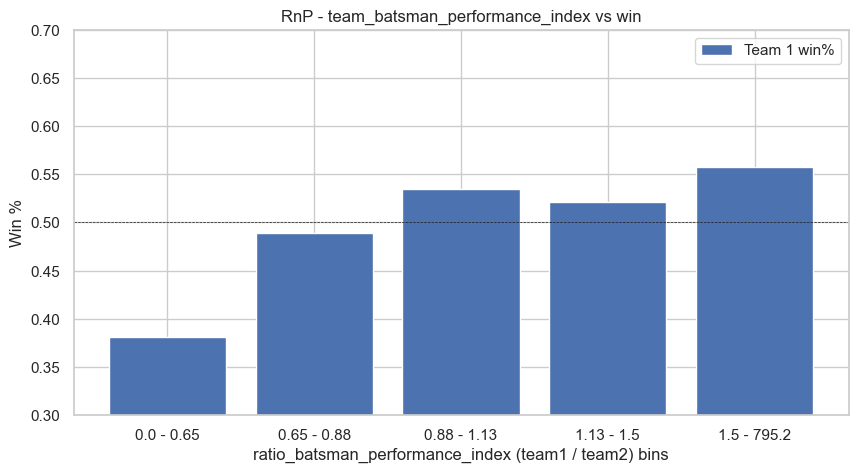

Correlation between team_batsman_performance_index and winner_01 is: -0.04003766613639936


In [74]:
createRnP(train_data, 'team_batsman_performance_index')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


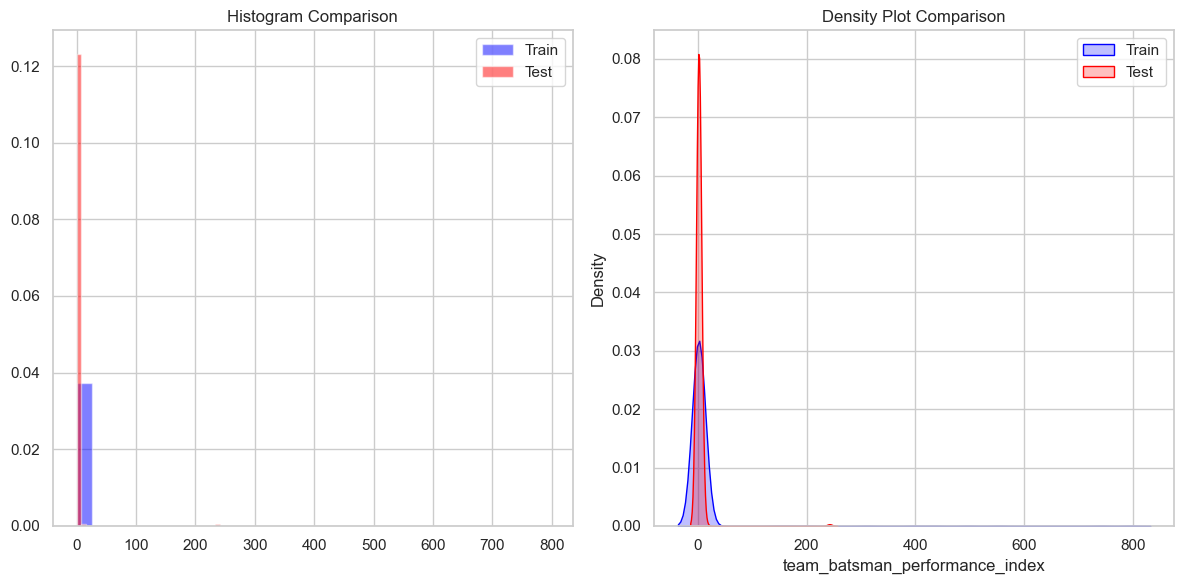

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8554

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.643986    2.142693
std      48.671236   14.668528
min       0.000000    0.000000
25%       0.725474    0.748330
50%       0.993099    1.037092
75%       1.400159    1.403964
max     795.199750  241.844000


In [75]:
check_distribution_match(train_data['team_batsman_performance_index'], test_data['team_batsman_performance_index'])

10. (Consider)

In [76]:
def overall_historical_win_rate(match_lvl_data, team_id, date):
    historical_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                        (match_lvl_data['match_dt'] < date)]
    wins = historical_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    total_matches = len(historical_matches)
    return wins / total_matches if total_matches > 0 else 0

In [77]:
train_data['team1_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

train_data = train_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

test_data['team1_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

test_data = test_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

slope: 0.57 / 0.43 =  1.33


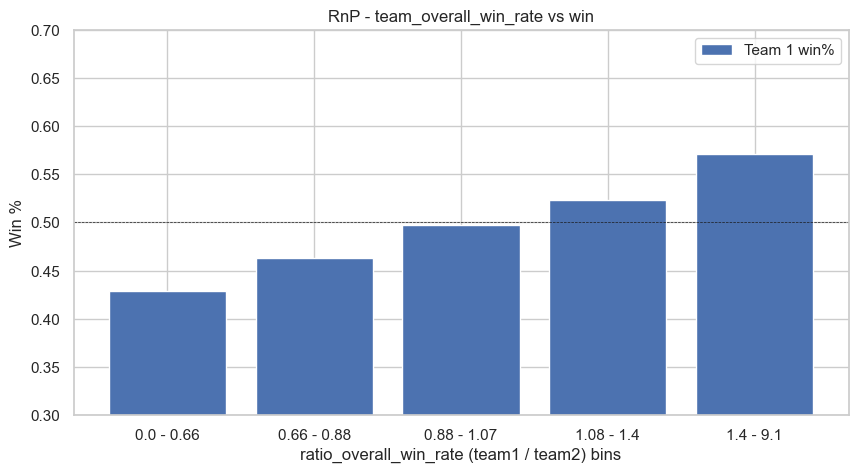

Correlation between team_overall_win_rate and winner_01 is: -0.0997730874267899


In [78]:
createRnP(train_data, 'team_overall_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


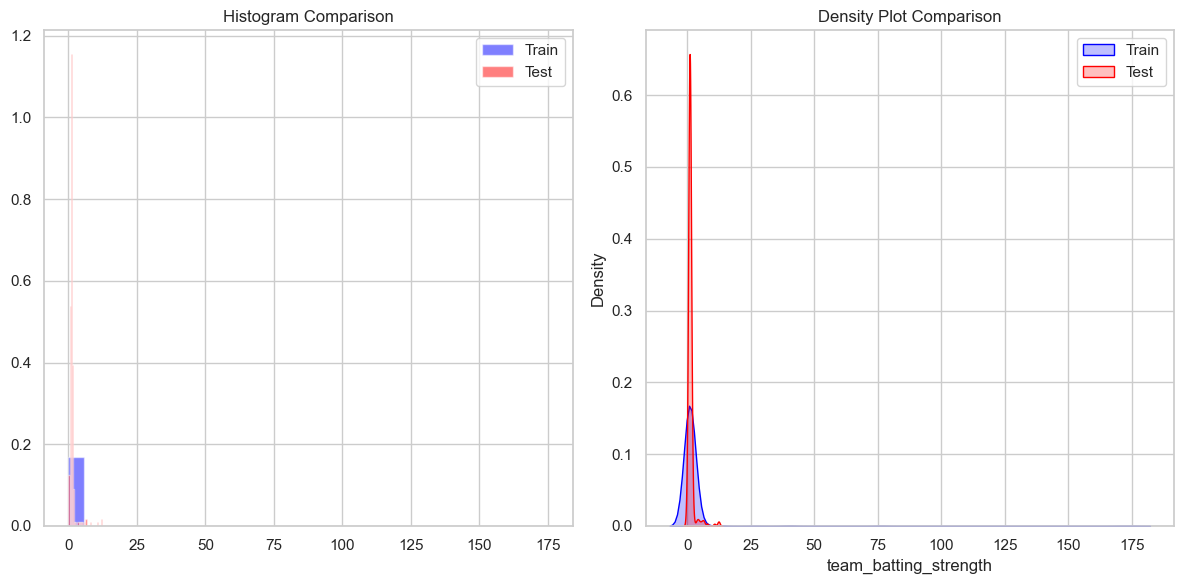

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.791761    1.270211
std       8.971790    1.436063
min       0.000000    0.000000
25%       0.813151    0.815097
50%       0.978937    0.993631
75%       1.189842    1.239880
max     175.363636   12.362069


In [79]:
check_distribution_match(train_data['team_overall_win_rate'], test_data['team_overall_win_rate'])

11.

In [80]:
def recent_form(match_lvl_data, team_id, date):
    recent_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['match_dt'] < date)].tail(5)
    wins = recent_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    return wins / 5 if recent_matches.shape[0] > 0 else 0

In [81]:
train_data['team1_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_recent_form'] = train_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

train_data = train_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

test_data['team1_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_recent_form'] = test_data.apply(
    lambda x: recent_form(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_recent_form', 'team2_recent_form', 'team_recent_form')

test_data = test_data.drop(columns=['team1_recent_form', 'team2_recent_form'])

slope: 0.53 / 0.44 =  1.21


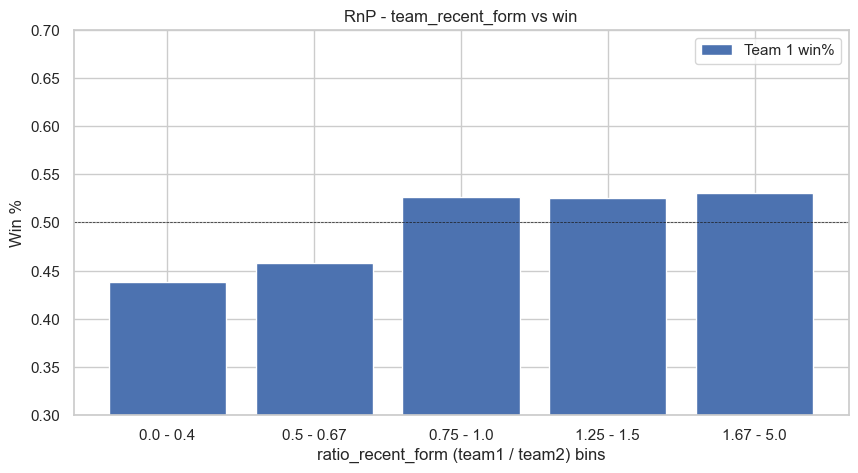

Correlation between team_recent_form and winner_01 is: -0.06215836793440212


In [82]:
createRnP(train_data, 'team_recent_form')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


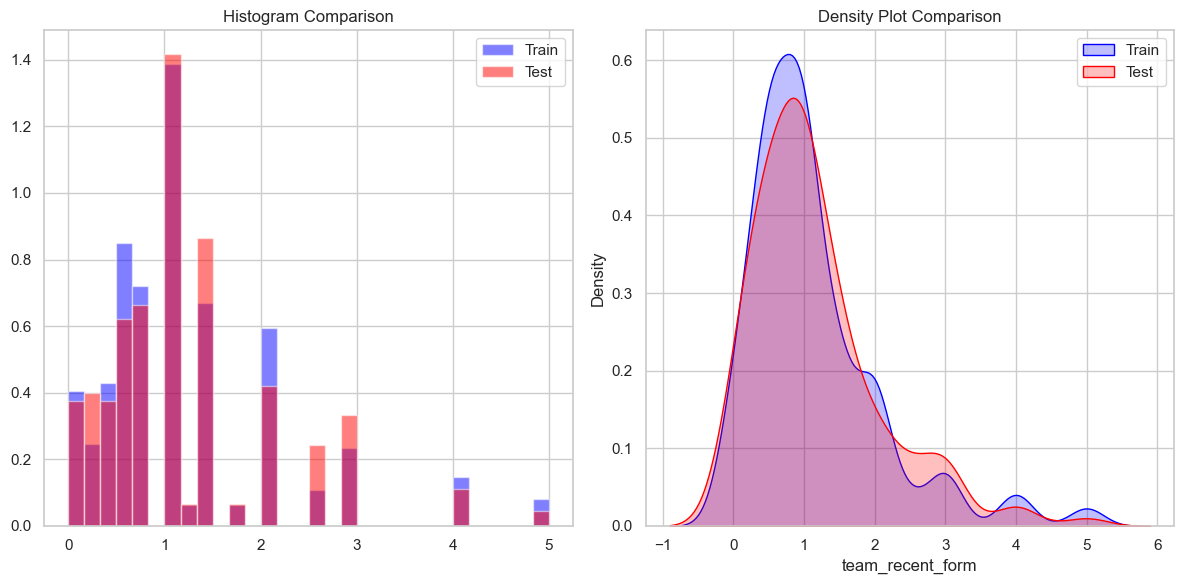

Kolmogorov-Smirnov test result: KS statistic = 0.0361, p-value = 0.9354

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.141842    1.164391
std       0.952862    0.917335
min       0.000000    0.000000
25%       0.500000    0.500000
50%       1.000000    1.000000
75%       1.500000    1.500000
max       5.000000    5.000000


In [83]:
check_distribution_match(train_data['team_recent_form'], test_data['team_recent_form'])

12.

In [84]:
def calculate_exponential_momentum(match_lvl_data, team_id, date, alpha=0.1):
    matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < date)].sort_values('match_dt', ascending=False)
    wins = matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).to_numpy()
    weights = np.exp(-alpha * np.arange(len(wins)))
    if np.sum(weights) > 0:
        momentum = np.dot(wins, weights) / np.sum(weights)
    else:
        momentum = 0  # Handle case with no matches
    return momentum

In [85]:
train_data['team1_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

train_data = train_data.drop(columns=['team1_momentum', 'team2_momentum'])

test_data['team1_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

test_data = test_data.drop(columns=['team1_momentum', 'team2_momentum'])

slope: 0.56 / 0.42 =  1.33


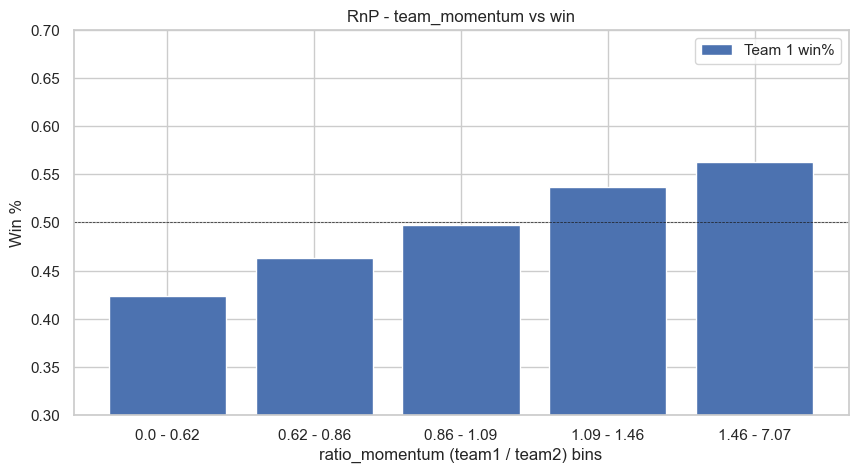

Correlation between team_momentum and winner_01 is: -0.09341226475457841


In [86]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


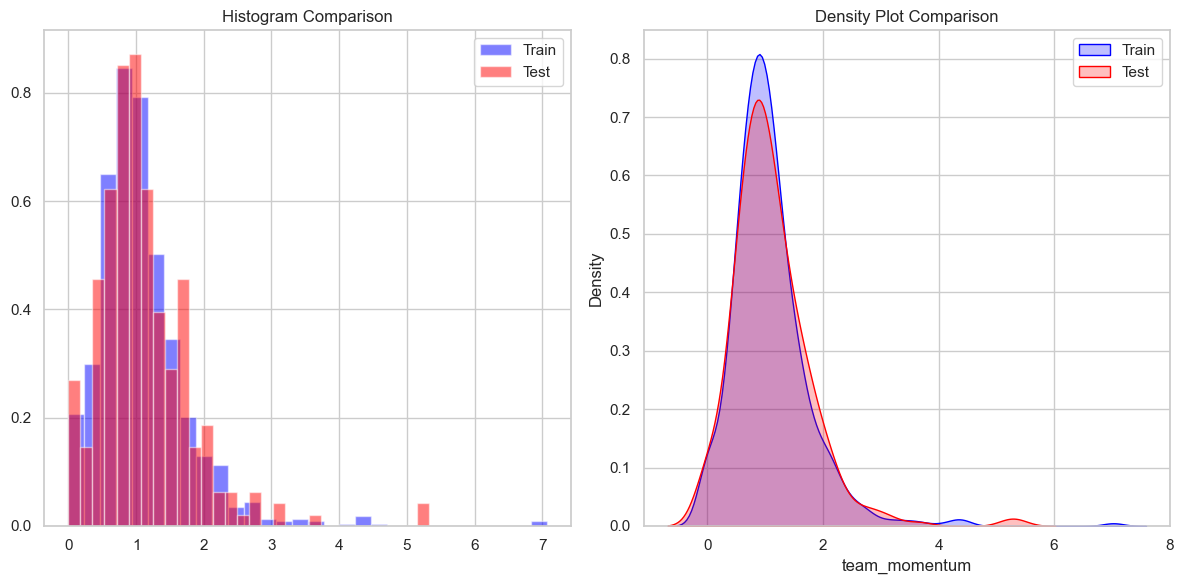

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.084422    1.105497
std       0.689988    0.701511
min       0.000000    0.000000
25%       0.682378    0.684016
50%       0.977013    0.987529
75%       1.347996    1.414583
max       7.065686    5.332317


In [87]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

13.

In [88]:
def team_batsman_performance_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 4.5 +
                                  recent_matches['strike_rate'] * 2.5 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] ) * 1.5) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [89]:
train_data['team1_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

train_data = train_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

test_data['team1_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

test_data = test_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

slope: 0.58 / 0.35 =  1.65


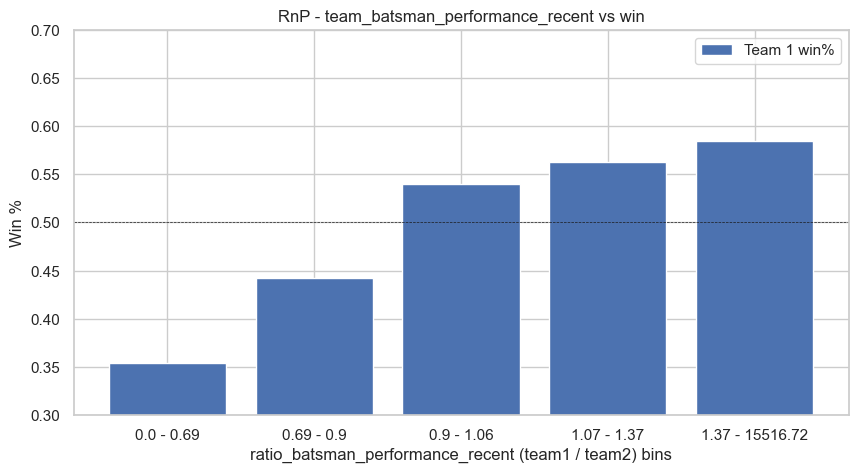

Correlation between team_batsman_performance_recent and winner_01 is: -0.04340818347684576


In [90]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


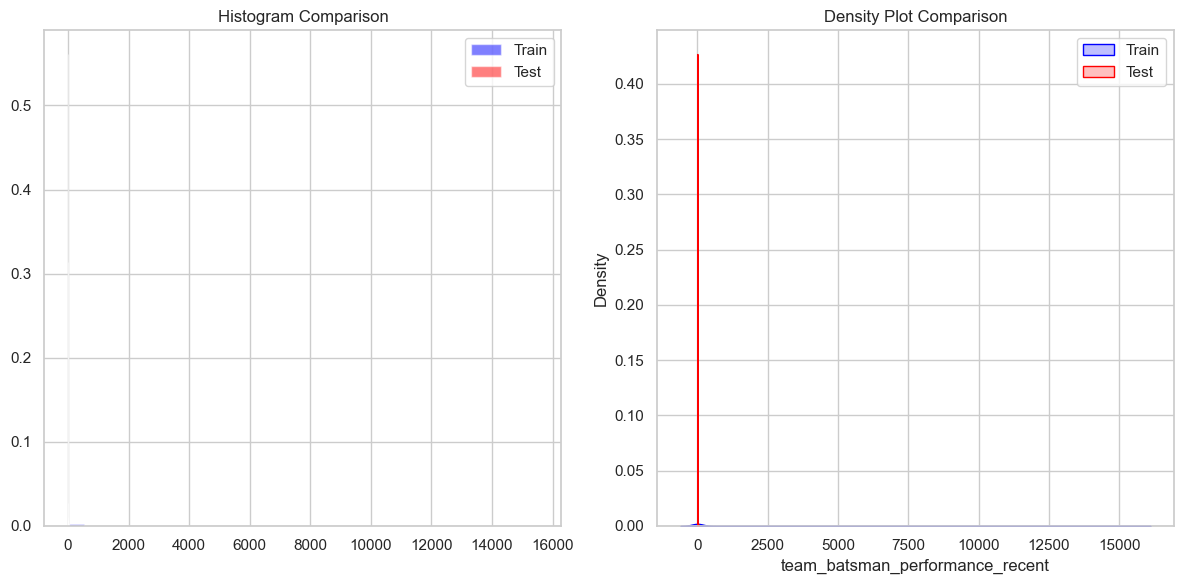

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean      60.915898    1.406714
std      785.743925    2.404311
min        0.000000    0.000000
25%        0.758679    0.748565
50%        0.977252    0.954295
75%        1.264147    1.312189
max    15516.725000   31.760455


In [91]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

14.

In [92]:
def team_batsman_runs_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] ) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

In [93]:
train_data['team1_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_runs_recent'] = train_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

train_data = train_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

test_data['team1_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_runs_recent'] = test_data.apply(
    lambda x: team_batsman_runs_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_runs_recent', 'team2_batsman_runs_recent', 'team_batsman_runs_recent')

test_data = test_data.drop(columns=['team1_batsman_runs_recent', 'team2_batsman_runs_recent'])

slope: 0.63 / 0.34 =  1.87


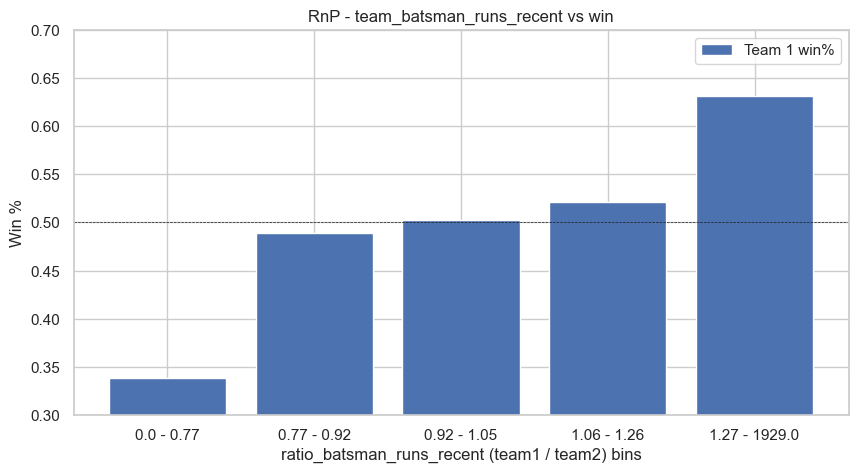

Correlation between team_batsman_runs_recent and winner_01 is: -0.05063885076794448


In [94]:
createRnP(train_data, 'team_batsman_runs_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


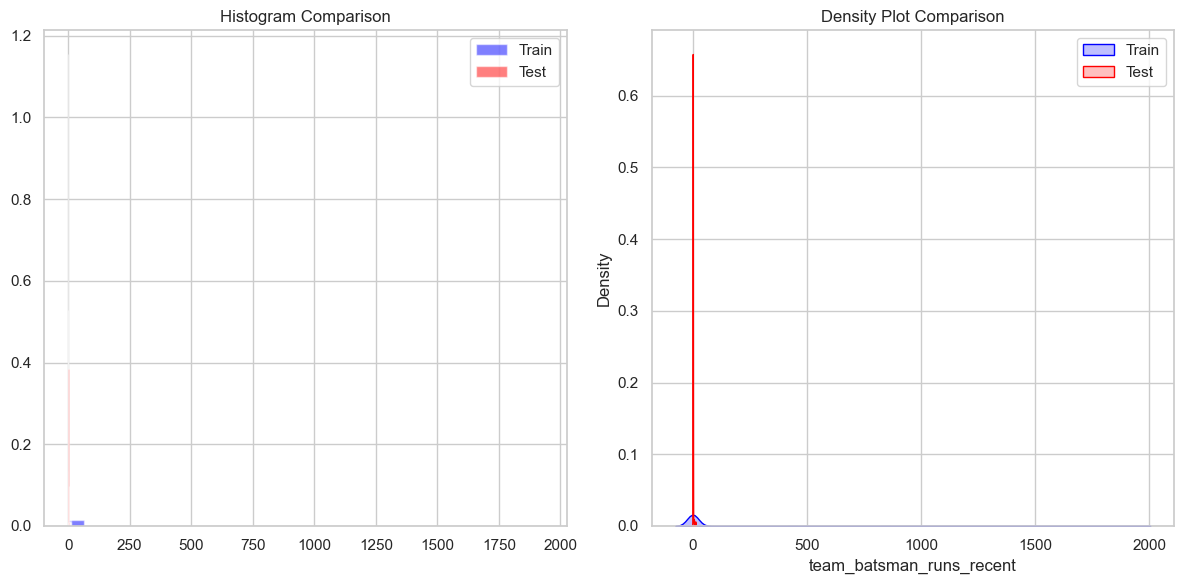

Kolmogorov-Smirnov test result: KS statistic = 0.0556, p-value = 0.5113

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      8.322739    1.270554
std      97.981448    1.435869
min       0.000000    0.000000
25%       0.815550    0.815097
50%       0.978937    0.993631
75%       1.190198    1.239880
max    1929.000000   12.362069


In [95]:
check_distribution_match(train_data['team_batsman_runs_recent'], test_data['team_batsman_runs_recent'])

15.

In [96]:
def player_of_match_frequency(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    pom_awards = 0
    total_matches = 0

    for player_id in team_ids:
        past_matches = matches[(matches['match_dt'] < date) & (matches['player_of_the_match_id'] == float(player_id))]
        pom_awards += past_matches.shape[0]
        total_matches += matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(str(player_id))) | (matches['team2_roster_ids'].str.contains(str(player_id))))].shape[0]

    return pom_awards / total_matches if total_matches > 0 else 0

In [97]:
train_data['team1_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

train_data = train_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

test_data['team1_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

test_data = test_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

slope: 0.53 / 0.39 =  1.36


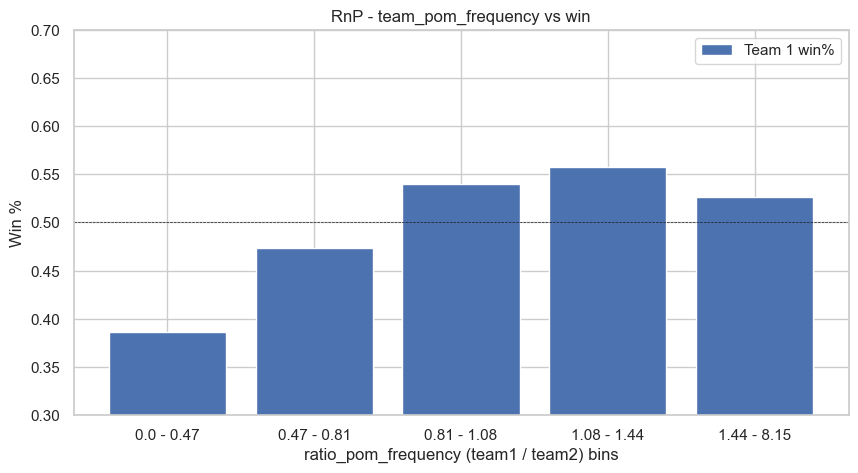

Correlation between team_pom_frequency and winner_01 is: -0.10387943593858757


In [98]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


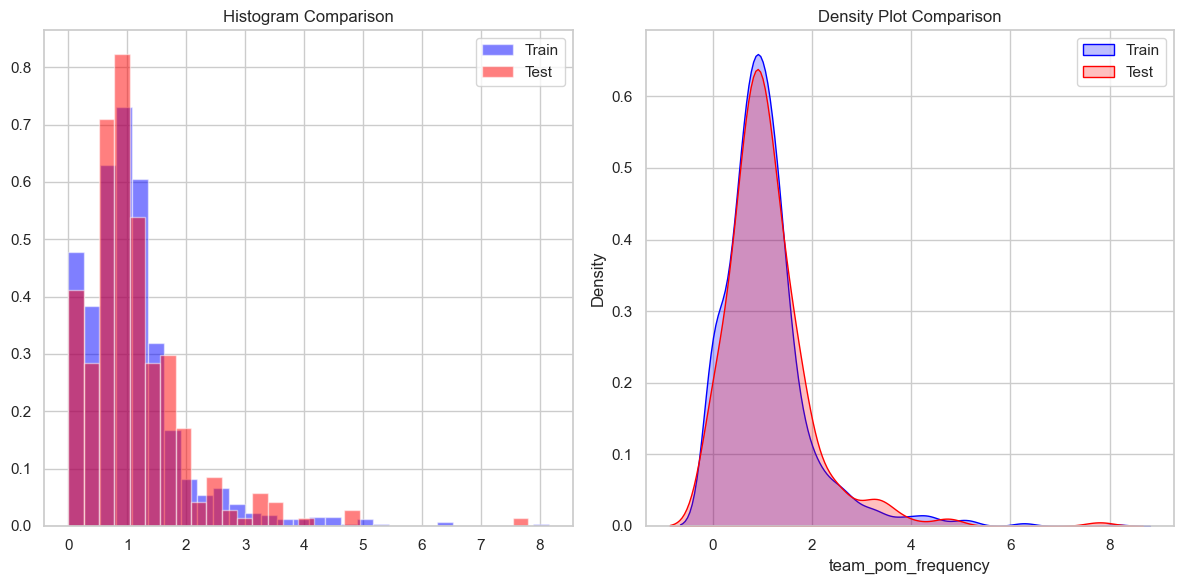

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.062113    1.116506
std       0.872368    0.888507
min       0.000000    0.000000
25%       0.575646    0.617815
50%       0.927612    0.960854
75%       1.323588    1.420928
max       8.151111    7.802120


In [99]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

15.

In [100]:
def team_count_100runs_last15(matches, team1_roster, team2_roster, date, n=25):
    def count_100s(team_roster):
        total_100s = 0
        for player_id in team_roster.split(':'):
            player_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
            total_100s += (player_matches['runs'] >= 75).sum()
        return total_100s

    team1_100s = count_100s(team1_roster)
    team2_100s = count_100s(team2_roster)

    return team1_100s / team2_100s if team2_100s > 0 else team1_100s

In [101]:
train_data['team_count_100runs_ratio_last15'] = train_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team_count_100runs_ratio_last15'] = test_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)

slope: 0.59 / 0.4 =  1.48


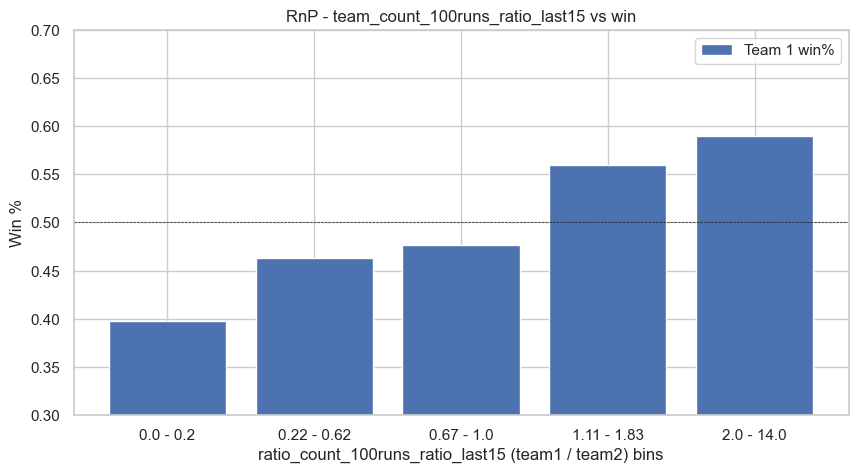

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14108232795000986


In [102]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


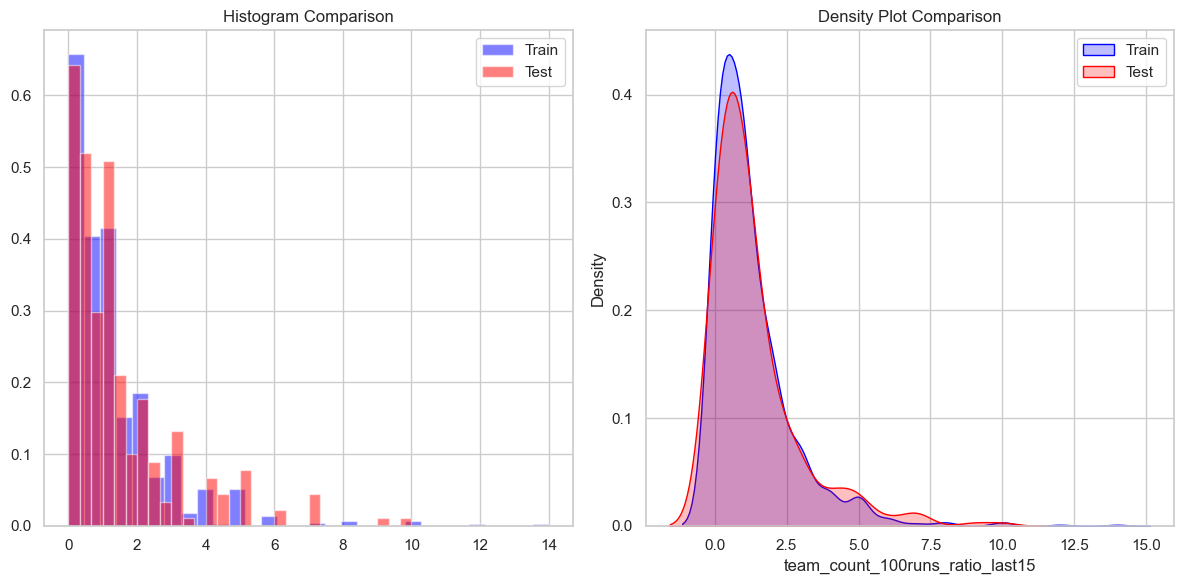

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.274676    1.365704
std       1.483916    1.597194
min       0.000000    0.000000
25%       0.333333    0.375000
50%       1.000000    1.000000
75%       1.750000    1.666667
max      14.000000   10.000000


In [103]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

16.

In [104]:
def win_percentage_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')) & (matches['match_dt'] < date)]
    wins = fielding_first_matches[fielding_first_matches['winner_id'] == team_id].shape[0]
    total_matches = fielding_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

In [105]:
train_data['team1_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

train_data = train_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

test_data['team1_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

test_data = test_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

slope: 0.65 / 0.29 =  2.24


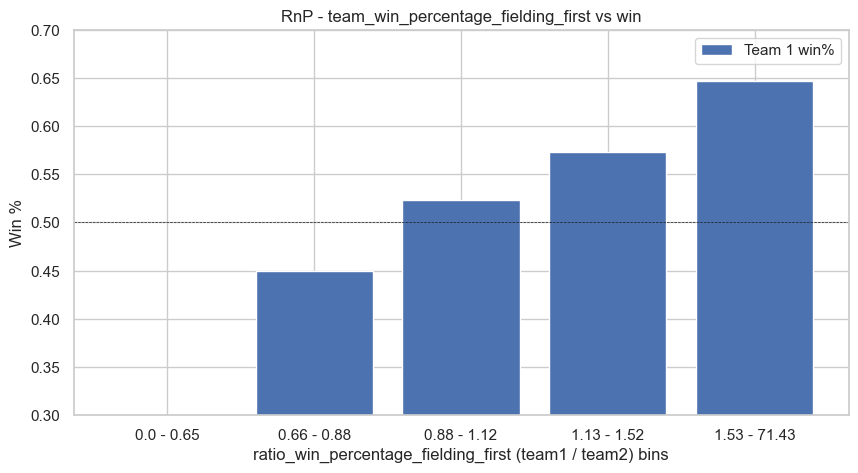

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.08742231380636549


In [106]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


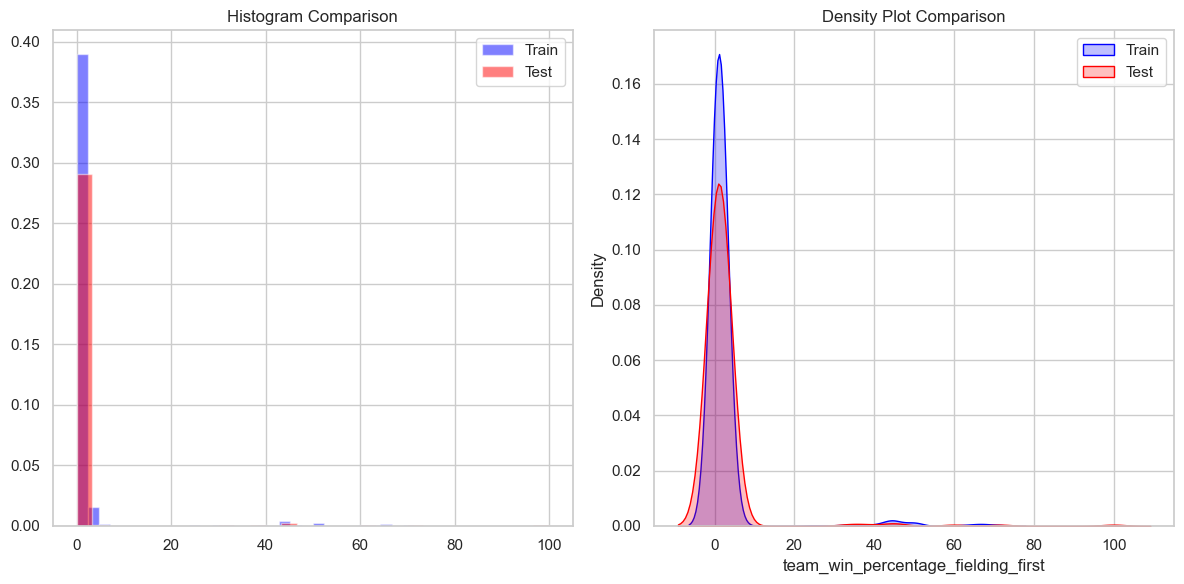

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.588952    2.489498
std       8.579653    9.424597
min       0.000000    0.000000
25%       0.715503    0.666667
50%       1.000000    1.000000
75%       1.370924    1.423962
max      71.428571  100.000000


In [107]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

17.

In [108]:
def avg_win_margin_runs(matches, team_id, date):
    win_by_runs_matches = matches[(matches['by'] == 'runs') & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)]
    total_margin = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id]['win amount'].sum()
    total_matches = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id].shape[0]
    return total_margin / total_matches if total_matches > 0 else 0

In [109]:
train_data['team1_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

train_data = train_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

test_data['team1_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

test_data = test_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

slope: 0.53 / 0.44 =  1.2


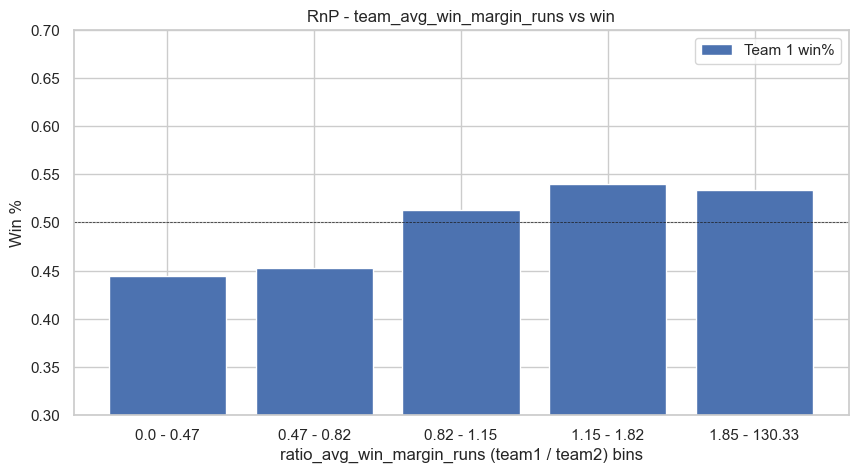

Correlation between team_avg_win_margin_runs and winner_01 is: -0.03073344181156112


In [110]:
createRnP(train_data, 'team_avg_win_margin_runs')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


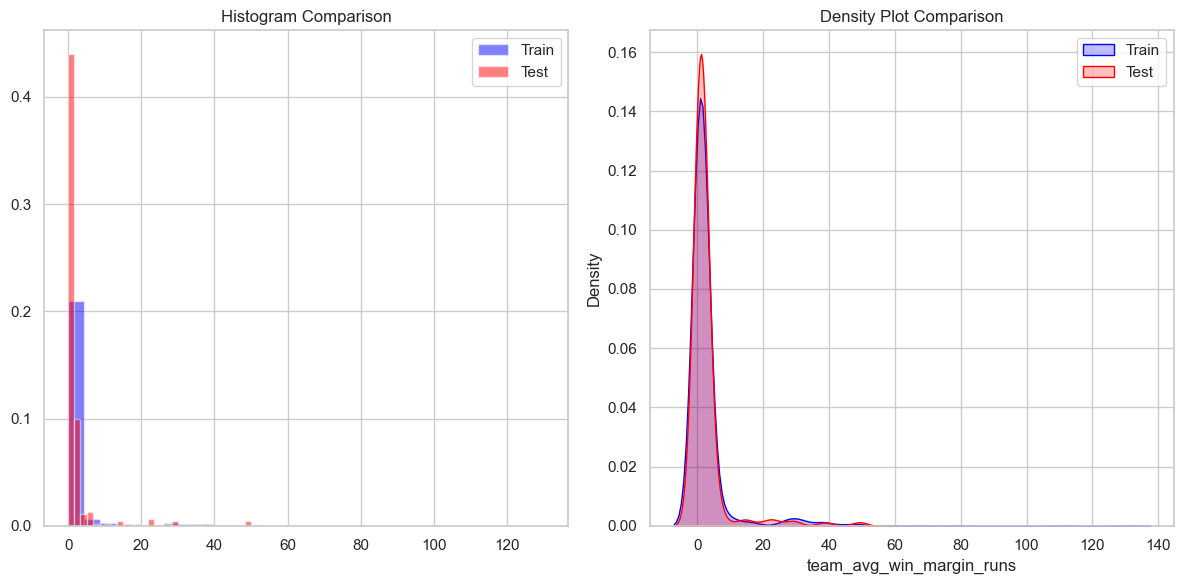

Kolmogorov-Smirnov test result: KS statistic = 0.0662, p-value = 0.2972

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.146298    2.660165
std       9.426177    6.618963
min       0.000000    0.000000
25%       0.589105    0.621948
50%       0.993953    1.024614
75%       1.597176    1.749286
max     130.333333   50.076923


In [111]:
check_distribution_match(train_data['team_avg_win_margin_runs'], test_data['team_avg_win_margin_runs'])

18.

In [112]:
def winpLastn_venue(team_id, date, ground_id,n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['ground_id']==ground_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [113]:
train_data['team1_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data['team2_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

train_data = train_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

test_data['team1_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data['team2_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

test_data = test_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

100%|██████████| 271/271 [00:00<00:00, 1472.09it/s]


slope: 0.56 / 0.4 =  1.42


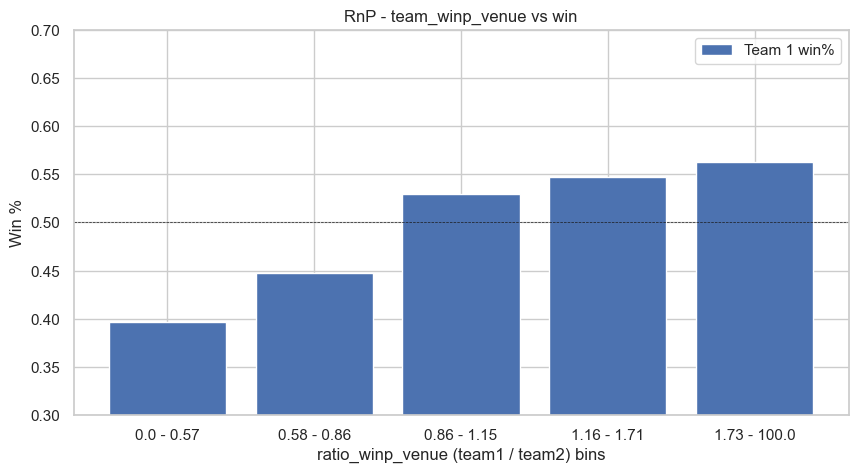

Correlation between team_winp_venue and winner_01 is: -0.05312515097696646


In [114]:
createRnP(train_data, 'team_winp_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


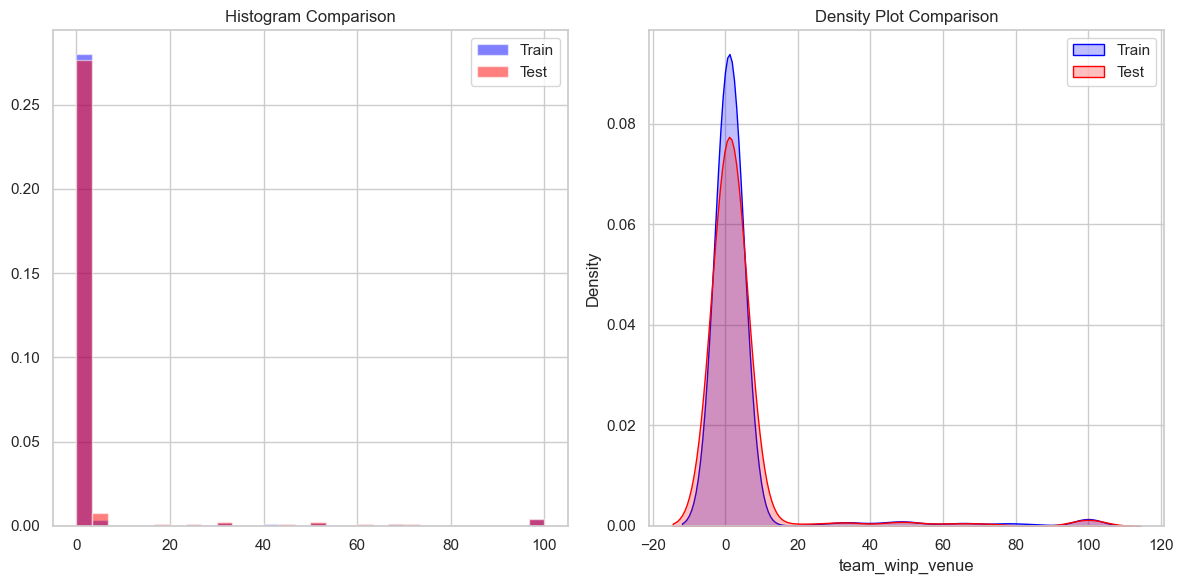

Kolmogorov-Smirnov test result: KS statistic = 0.0630, p-value = 0.3556

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      4.492258    4.253280
std      15.602713   14.798107
min       0.000000    0.000000
25%       0.650037    0.687004
50%       1.000000    1.047612
75%       1.500150    1.658566
max     100.000000  100.000000


In [115]:
check_distribution_match(train_data['team_winp_venue'], test_data['team_winp_venue'])

Continue....

19.

In [116]:
def assign_toss_winner_flag(row):
    if row['team1'] == row['toss winner']:
        return row['team1_id']
    elif row['team2'] == row['toss winner']:
        return row['team2_id']
train_data['toss_winner_id'] = train_data.apply(assign_toss_winner_flag, axis=1)
match_lvl_data['toss_winner_id'] = match_lvl_data.apply(assign_toss_winner_flag, axis=1)
test_data['toss_winner_id']= test_data.apply(assign_toss_winner_flag, axis=1)

def assign_bat(row):
    if (row['toss_winner_id'] == row['team1_id']) & (row['toss decision']=='bat'):
        return row['team1_id']
    if (row['toss_winner_id'] != row['team1_id']) & (row['toss decision']=='field'):
        return row['team1_id']
    else:
        return row['team2_id']
train_data['bat_id'] = train_data.apply(assign_bat, axis=1) 
match_lvl_data['bat_id'] = match_lvl_data.apply(assign_bat, axis=1)
test_data['bat_id'] = test_data.apply(assign_bat, axis=1)

In [117]:
def teamAvgRunsLastn_innings1(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning1_runs'].mean()

In [118]:
train_data['runs_team1_1st_inning']= train_data.progress_apply(lambda x: \
                                 teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['runs_team2_1st_inning']= train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

train_data = train_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

test_data['runs_team1_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['runs_team2_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

test_data = test_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

100%|██████████| 271/271 [00:00<00:00, 1589.37it/s]


slope: 0.55 / 0.44 =  1.25


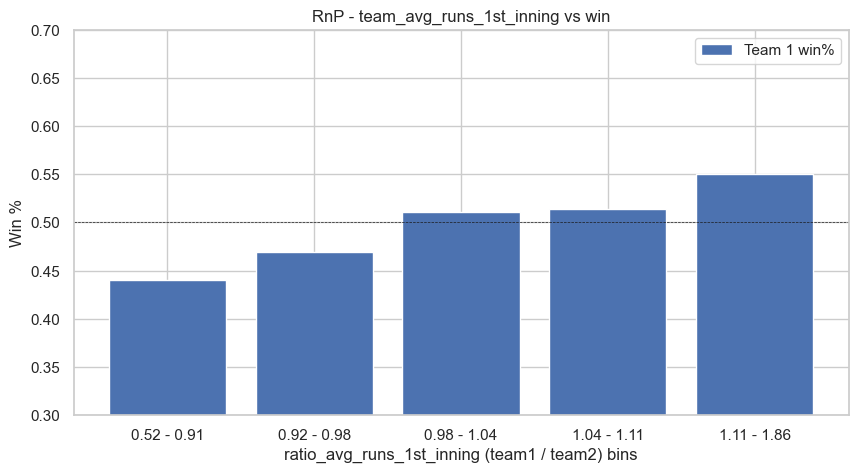

Correlation between team_avg_runs_1st_inning and winner_01 is: -0.08210253516941837


In [119]:
createRnP(train_data, 'team_avg_runs_1st_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


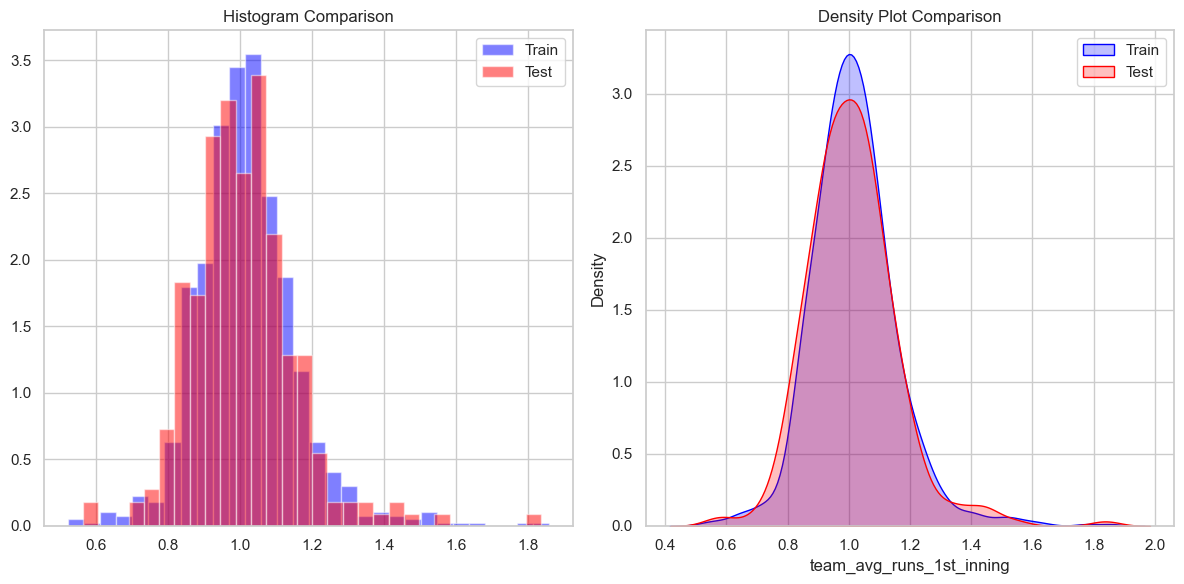

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.016814    1.009674
std       0.141082    0.147750
min       0.523536    0.563282
25%       0.931371    0.919311
50%       1.007966    1.001393
75%       1.087347    1.082585
max       1.858280    1.838217


In [120]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

20.

In [121]:
def EcoLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['economy']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty

In [122]:
train_data['team1_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

train_data = train_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

test_data['team1_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

test_data = test_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

100%|██████████| 271/271 [00:04<00:00, 60.54it/s]


slope: 0.57 / 0.45 =  1.27


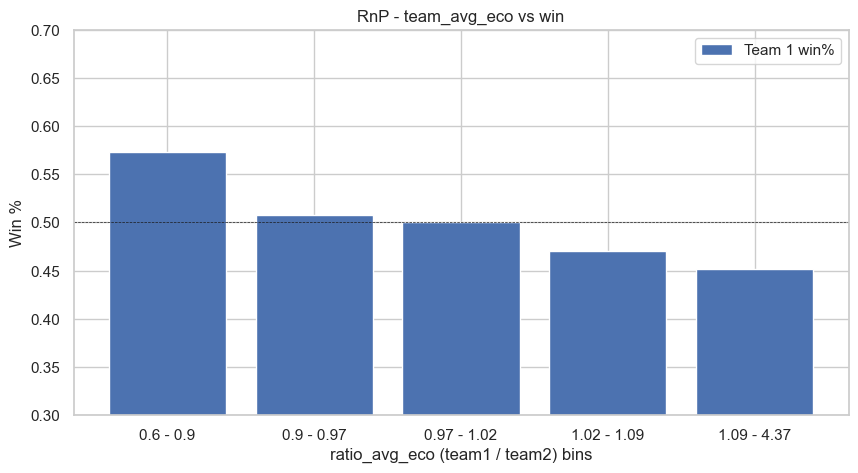

Correlation between team_avg_eco and winner_01 is: 0.029889408874522787


In [123]:
createRnP(train_data, 'team_avg_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


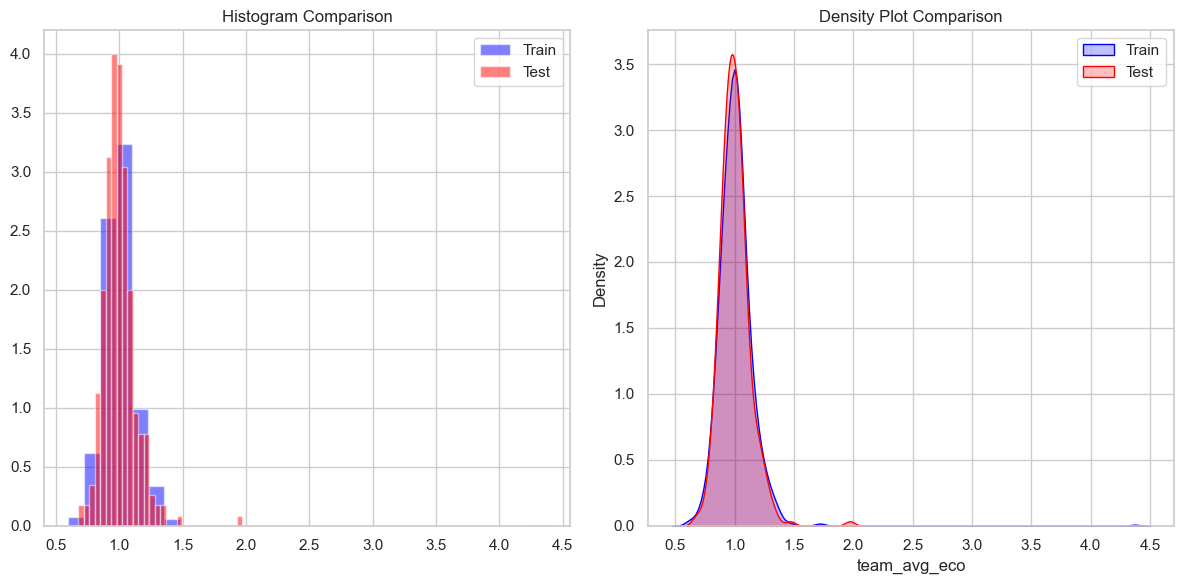

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   927.000000  267.000000
mean      1.006520    0.997867
std       0.168425    0.130098
min       0.598698    0.676974
25%       0.921918    0.920045
50%       0.997530    0.985647
75%       1.065874    1.052922
max       4.371515    1.969705


In [124]:
check_distribution_match(train_data['team_avg_eco'], test_data['team_avg_eco'])

## Harshit

In [125]:
def consistency_index(matches, team_id, date, n=5):
    recent_matches = matches[((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)].sort_values(by='match_dt', ascending=False).head(n)
    total_matches = recent_matches.shape[0]
    if total_matches == 0:
        return 0
    
    wins = recent_matches[recent_matches['winner_id'] == team_id].shape[0]
    win_percentage = (wins / total_matches) * 100
    return win_percentage

# Apply to training data
train_data['team1_consistency_index'] = train_data.apply(lambda x: consistency_index(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_consistency_index'] = train_data.apply(lambda x: consistency_index(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_consistency_index', 'team2_consistency_index', 'consistency_index_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_consistency_index', 'team2_consistency_index'])

# Apply to test data
test_data['team1_consistency_index'] = test_data.apply(lambda x: consistency_index(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_consistency_index'] = test_data.apply(lambda x: consistency_index(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_consistency_index', 'team2_consistency_index', 'consistency_index_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_consistency_index', 'team2_consistency_index'])


slope: 0.58 / 0.41 =  1.44


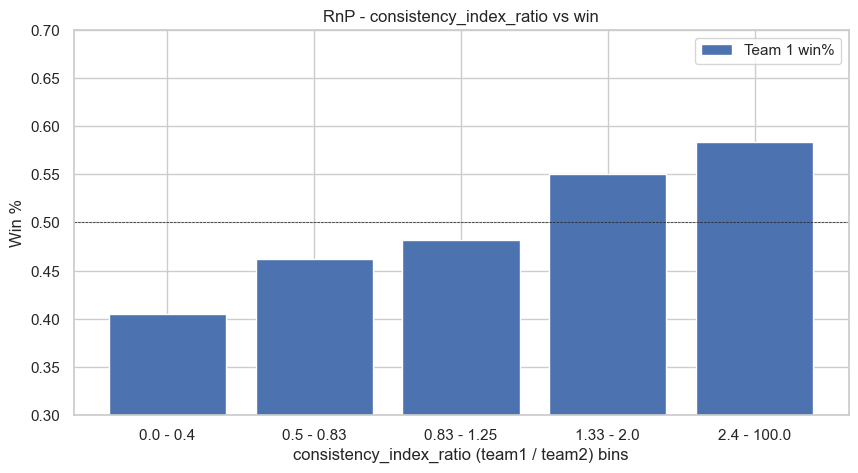

Correlation between consistency_index_ratio and winner_01 is: -0.011988735319849479


In [126]:
createRnP(train_data, 'consistency_index_ratio')

In [127]:
# Function to calculate average wickets taken batting first
def avg_wickets_taken_batting_first(matches, team_id, date):
    batting_first_matches = matches[(matches['match_dt'] < date) & (((matches['team1_id'] == team_id) & (matches['toss decision'] == 'bat')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')))]
    wickets_taken = batting_first_matches.apply(lambda x: x['inning2_wickets'] if x['team1_id'] == team_id else x['inning1_wickets'], axis=1).sum()
    total_matches = batting_first_matches.shape[0]
    return wickets_taken / total_matches if total_matches > 0 else 0

# Apply to training data
train_data['team1_avg_wickets_taken_batting_first'] = train_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_taken_batting_first'] = train_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first', 'avg_wickets_taken_batting_first_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first'])

# Apply to test data
test_data['team1_avg_wickets_taken_batting_first'] = test_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_taken_batting_first'] = test_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first', 'avg_wickets_taken_batting_first_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first'])


slope: 0.55 / 0.4 =  1.39


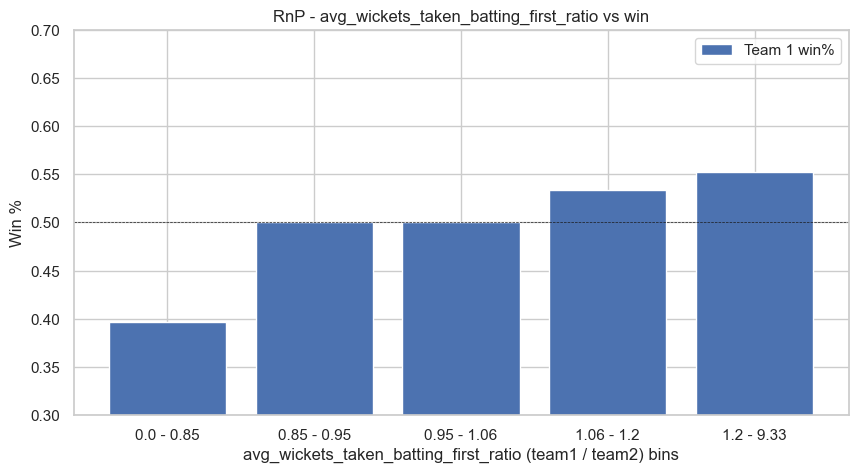

Correlation between avg_wickets_taken_batting_first_ratio and winner_01 is: -0.04510259271532462


In [128]:
createRnP(train_data, 'avg_wickets_taken_batting_first_ratio')

In [129]:
# Function to calculate average wickets conceded fielding first
def avg_wickets_conceded_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[(matches['match_dt'] < date) & (((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'bat')))]
    wickets_conceded = fielding_first_matches.apply(lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1).sum()
    total_matches = fielding_first_matches.shape[0]
    return wickets_conceded / total_matches if total_matches > 0 else 0

# Apply to training data
train_data['team1_avg_wickets_conceded_fielding_first'] = train_data.apply(lambda x: avg_wickets_conceded_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_conceded_fielding_first'] = train_data.apply(lambda x: avg_wickets_conceded_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_avg_wickets_conceded_fielding_first', 'team2_avg_wickets_conceded_fielding_first', 'avg_wickets_conceded_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_wickets_conceded_fielding_first', 'team2_avg_wickets_conceded_fielding_first'])

# Apply to test data
test_data['team1_avg_wickets_conceded_fielding_first'] = test_data.apply(lambda x: avg_wickets_conceded_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_conceded_fielding_first'] = test_data.apply(lambda x: avg_wickets_conceded_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_avg_wickets_conceded_fielding_first', 'team2_avg_wickets_conceded_fielding_first', 'avg_wickets_conceded_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_wickets_conceded_fielding_first', 'team2_avg_wickets_conceded_fielding_first'])


slope: 0.51 / 0.46 =  1.11


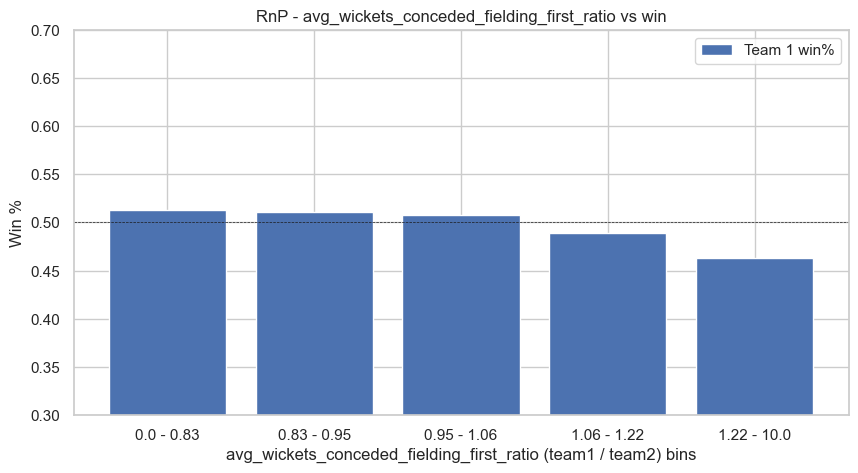

Correlation between avg_wickets_conceded_fielding_first_ratio and winner_01 is: -0.032263735179636446


In [130]:
createRnP(train_data, 'avg_wickets_conceded_fielding_first_ratio')

## More Features

In [131]:
def team_win_rate_at_ground(team_id, ground_id, date, n):
    # Filter matches with specified team and ground, before the given date
    relevant_games = match_lvl_data[(match_lvl_data['match_dt'] < date) &
                                    ((match_lvl_data['team1_id'] == team_id) |
                                     (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['ground_id'] == ground_id)].sort_values(by='match_dt', ascending=False).head(n)

    # Calculate wins
    wins = relevant_games.apply(lambda x: 1 if x['winner_id'] == team_id else 0, axis=1).sum()

    # Calculate win rate
    if len(relevant_games) > 0:
        win_rate = wins / len(relevant_games)
    else:
        win_rate = 0  # No games to calculate from

    return win_rate

In [132]:
train_data['team1_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
train_data['team2_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

train_data = train_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

test_data['team1_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
test_data['team2_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

test_data = test_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

100%|██████████| 271/271 [00:00<00:00, 1205.76it/s]


slope: 0.56 / 0.47 =  1.2


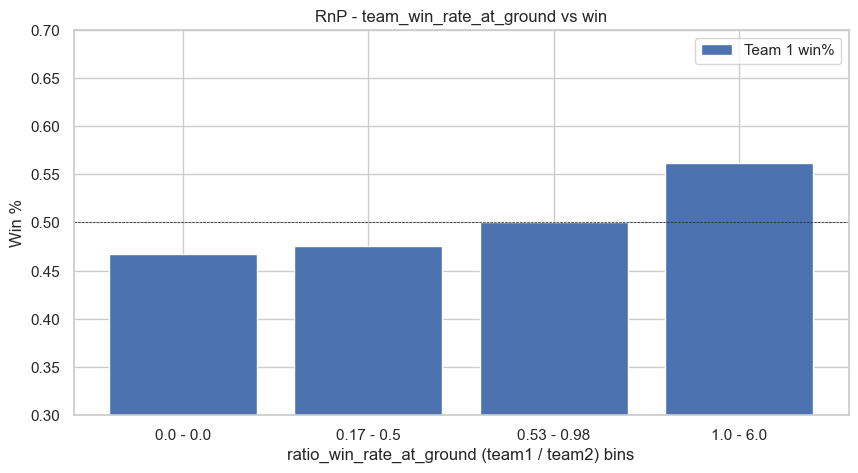

Correlation between team_win_rate_at_ground and winner_01 is: -0.05370441711356502


In [133]:
createRnP(train_data, 'team_win_rate_at_ground')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


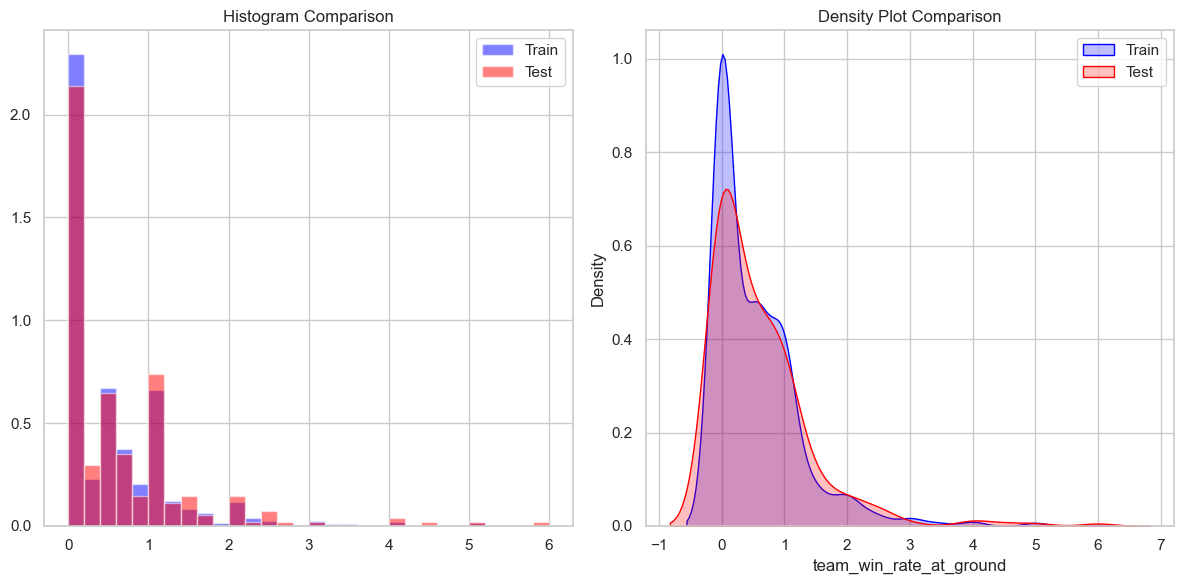

Kolmogorov-Smirnov test result: KS statistic = 0.0436, p-value = 0.7969

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542720    0.610622
std       0.740211    0.848291
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.937500    1.000000
max       6.000000    6.000000


In [134]:
check_distribution_match(train_data['team_win_rate_at_ground'], test_data['team_win_rate_at_ground'])

In [135]:
def calculate_batsman_strike_rate(player_list, date, n):
    player_list = str(player_list).split(':')  # Split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        runs = recent_matches['runs'].sum()
        balls = recent_matches['balls_faced'].sum()

        # Calculate strike rate and avoid division by zero
        if balls > 0:
            strike_rate = (runs / balls) * 100
        else:
            strike_rate = 0

        res_list.append(strike_rate)

    # Calculate the average strike rate across all players in the list
    if res_list:  # Ensure the list is not empty to avoid division by zero
        average_strike_rate = sum(res_list) / len(res_list)
    else:
        average_strike_rate = 0

    return average_strike_rate

In [136]:
train_data['team1_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

train_data = train_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

test_data['team1_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

test_data = test_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

100%|██████████| 271/271 [00:04<00:00, 61.49it/s]


slope: 0.55 / 0.42 =  1.32


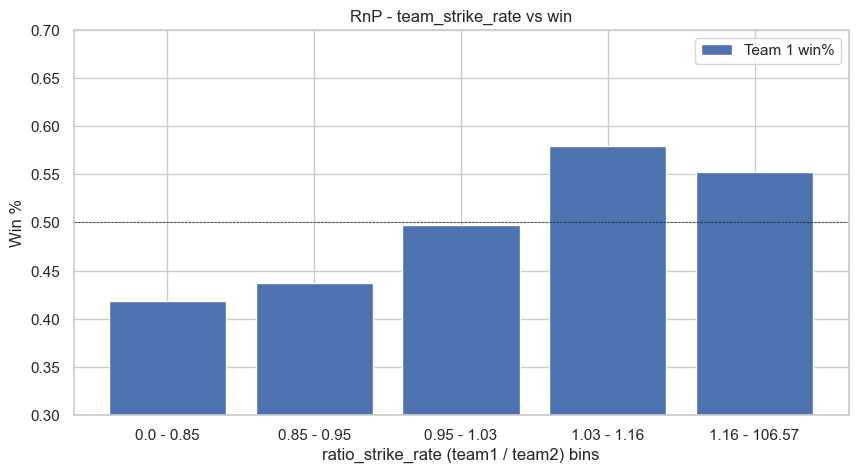

Correlation between team_strike_rate and winner_01 is: -0.046993779948201454


In [137]:
createRnP(train_data, 'team_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


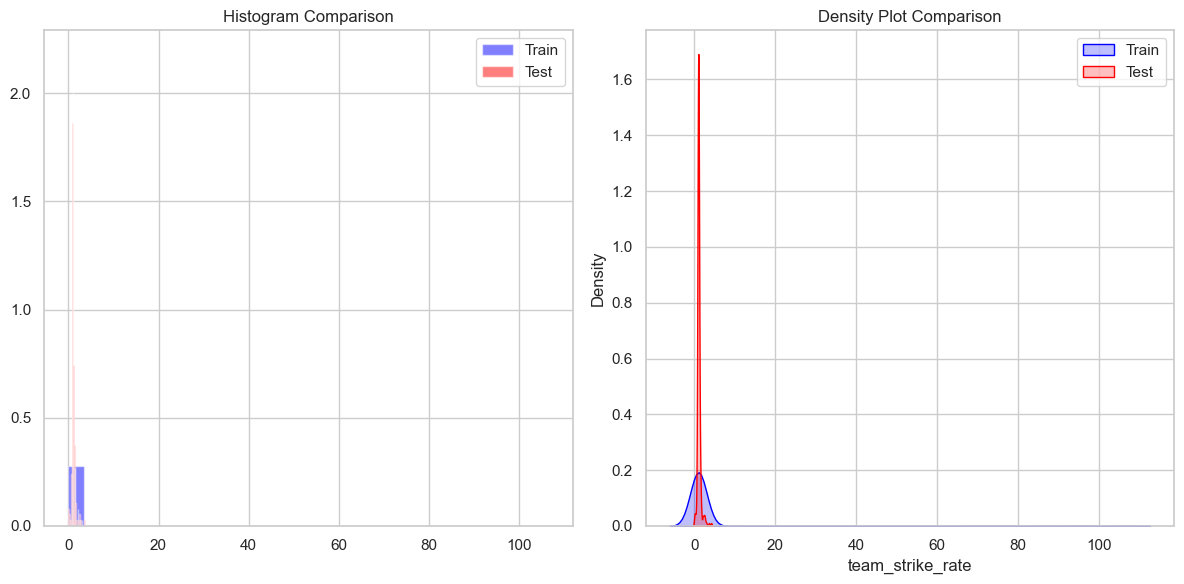

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.752818    1.056381
std       7.980454    0.426486
min       0.000000    0.000000
25%       0.887845    0.885572
50%       0.997539    0.998391
75%       1.115476    1.108754
max     106.574684    4.162338


In [138]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

In [139]:
def adjusted_team_venue_win_rate(match_lvl_data, team_id, venue_id, date):
    # Filter matches at the venue for the specific team before the given date
    venue_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                   ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                   (match_lvl_data['match_dt'] < date)]
    # Calculate basic win rate
    wins = venue_matches[venue_matches['winner_id'] == team_id].shape[0]
    total = venue_matches.shape[0]
    win_rate = wins / total if total > 0 else 0

    # Adjust win rate by recent form (last 5 matches)
    recent_form = venue_matches.tail(5)
    recent_wins = recent_form[recent_form['winner_id'] == team_id].shape[0]
    recent_total = recent_form.shape[0]
    recent_win_rate = recent_wins / recent_total if recent_total > 0 else 0

    # Combine basic and recent win rates
    if total > 0:
        adjusted_win_rate = (win_rate * 0.75) + (recent_win_rate * 0.25)
    else:
        adjusted_win_rate = 0

    return adjusted_win_rate

In [140]:
train_data['team1_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
train_data['team2_adjusted_win_rate_at_venue'] = train_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

test_data['team1_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team1_id'], x['ground_id'], x['match_dt']),
    axis=1
)
test_data['team2_adjusted_win_rate_at_venue'] = test_data.apply(
    lambda x: adjusted_team_venue_win_rate(match_lvl_data, x['team2_id'], x['ground_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue', 'team_adjusted_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_adjusted_win_rate_at_venue', 'team2_adjusted_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.19


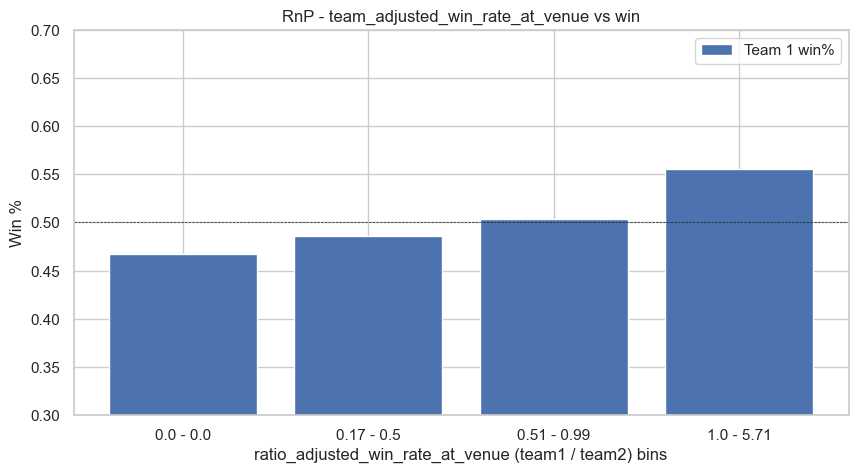

Correlation between team_adjusted_win_rate_at_venue and winner_01 is: -0.052518248499160855


In [141]:
createRnP(train_data, 'team_adjusted_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


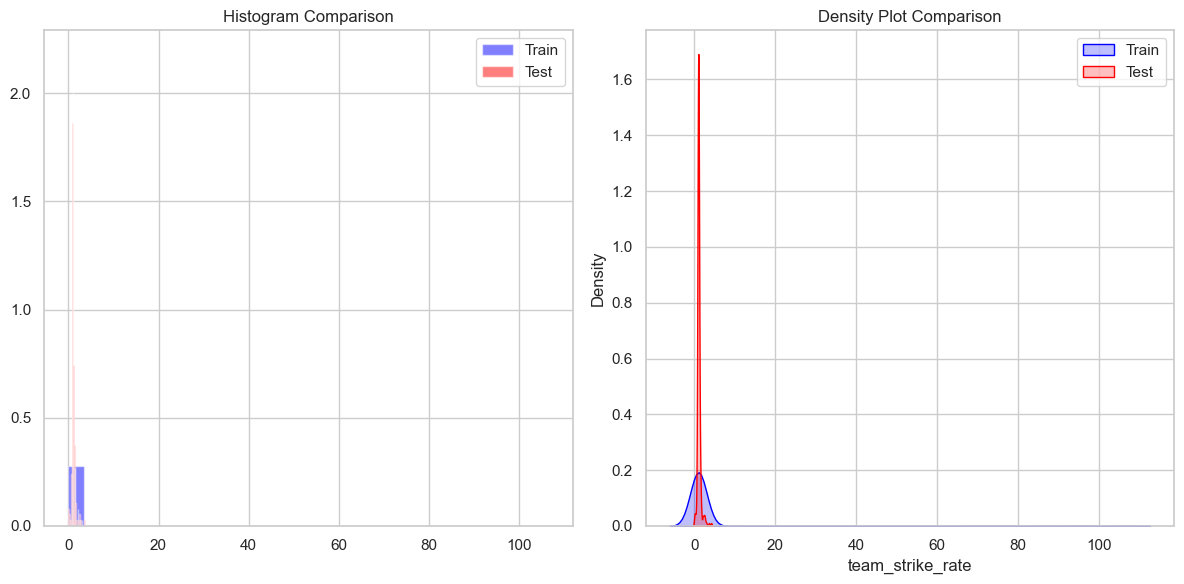

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.752818    1.056381
std       7.980454    0.426486
min       0.000000    0.000000
25%       0.887845    0.885572
50%       0.997539    0.998391
75%       1.115476    1.108754
max     106.574684    4.162338


In [142]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

In [143]:
def scoring_variance_at_venue(match_lvl_data, team_id, venue, match_dt):
    scores = match_lvl_data[((match_lvl_data['venue'] == venue) &
                             ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < match_dt))].apply(
        lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'],
        axis=1
    )
    if len(scores) > 1:
        return np.var(scores)
    return None  # Not applicable if fewer than 2 scores

In [144]:
train_data['team1_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
train_data['team2_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

train_data = train_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

test_data['team1_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
test_data['team2_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

test_data = test_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

slope: 0.67 / 0.42 =  1.6


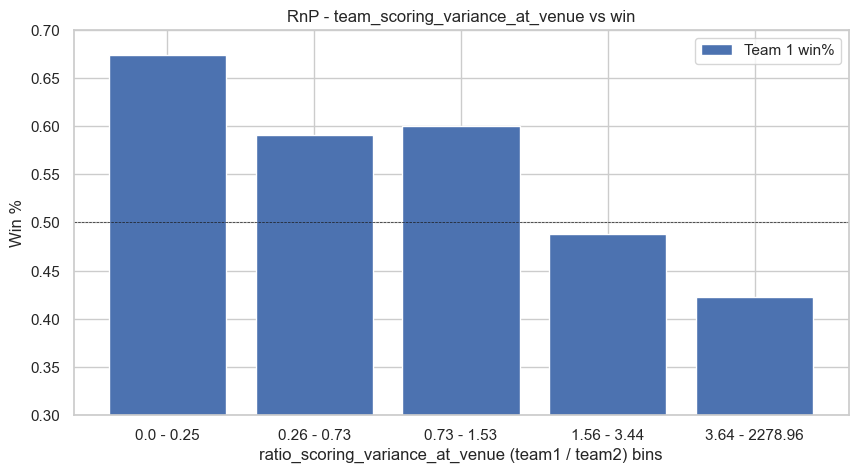

Correlation between team_scoring_variance_at_venue and winner_01 is: 0.07382813750939758


In [145]:
createRnP(train_data, 'team_scoring_variance_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


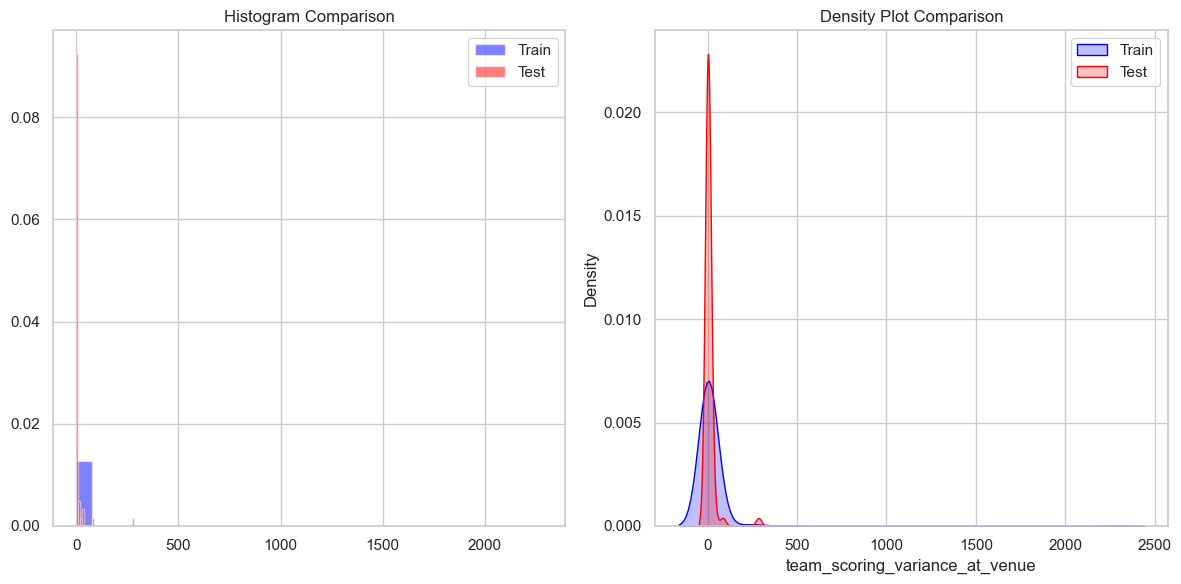

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   220.000000   64.000000
mean     20.670464    8.811408
std     159.135882   36.995710
min       0.002268    0.000000
25%       0.391702    0.410554
50%       1.154405    1.040817
75%       2.456717    2.601452
max    2278.958333  284.305556


In [146]:
check_distribution_match(train_data['team_scoring_variance_at_venue'], test_data['team_scoring_variance_at_venue'])

In [147]:
def avg_partnership_length(matches, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    total_partnership_runs = 0
    total_partnerships = 0

    for player_id in team_ids[:6]:  # Assuming top 4 are the main batsmen
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
        total_partnership_runs += recent_matches['runs'].sum()
        total_partnerships += recent_matches.shape[0]

    return total_partnership_runs / total_partnerships if total_partnerships > 0 else 0

In [148]:
train_data['team1_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_avg_partnership_length'] = train_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length')

train_data = train_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])

test_data['team1_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_avg_partnership_length'] = test_data.apply(lambda x: avg_partnership_length(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_partnership_length', 'team2_avg_partnership_length', 'team_avg_partnership_length')

test_data = test_data.drop(columns=['team1_avg_partnership_length', 'team2_avg_partnership_length'])

slope: 0.58 / 0.45 =  1.29


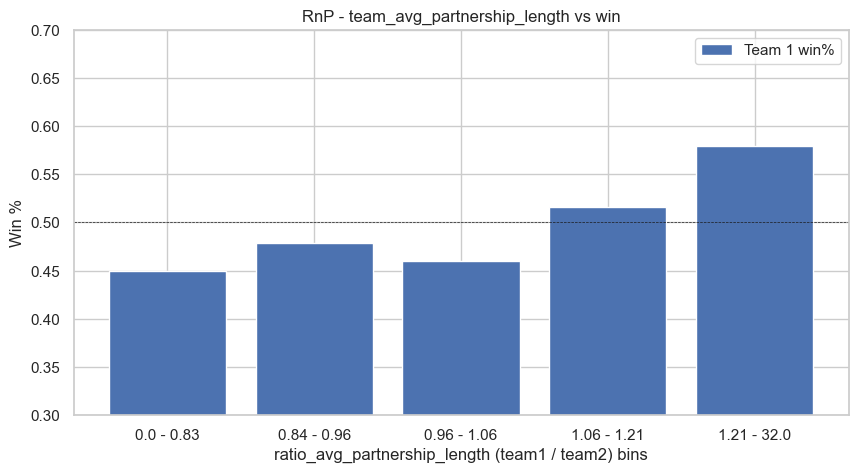

Correlation between team_avg_partnership_length and winner_01 is: -0.019392684698191665


In [149]:
createRnP(train_data, 'team_avg_partnership_length')    

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


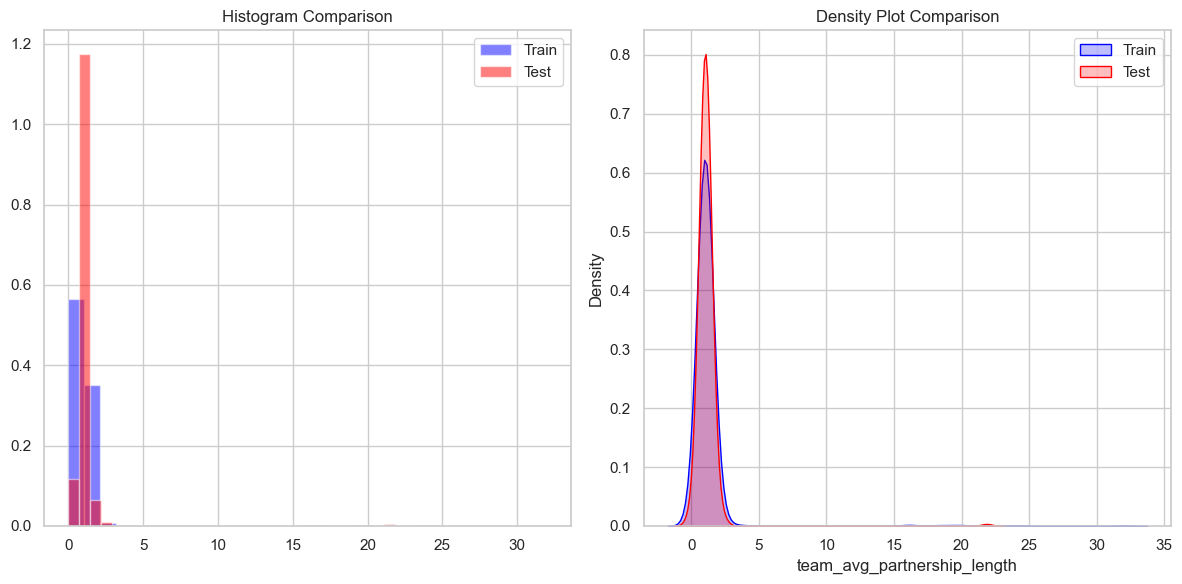

Kolmogorov-Smirnov test result: KS statistic = 0.0319, p-value = 0.9775

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.276472    1.107867
std       2.256012    1.299572
min       0.000000    0.000000
25%       0.869373    0.870976
50%       1.016158    1.027321
75%       1.169077    1.173778
max      32.000000   21.857143


In [150]:
check_distribution_match(train_data['team_avg_partnership_length'], test_data['team_avg_partnership_length'])

In [151]:
def win_percentage_batting_first(matches, team_id, date):
    batting_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'bat')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'bat')) & (matches['match_dt'] < date)]
    wins = batting_first_matches[batting_first_matches['winner_id'] == team_id].shape[0]
    total_matches = batting_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

In [152]:
train_data['team1_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_batting_first'] = train_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'team_win_percentage_batting_first')

train_data = train_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])

test_data['team1_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_batting_first'] = test_data.apply(lambda x: win_percentage_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_batting_first', 'team2_win_percentage_batting_first', 'team_win_percentage_batting_first')

test_data = test_data.drop(columns=['team1_win_percentage_batting_first', 'team2_win_percentage_batting_first'])

slope: 0.61 / 0.34 =  1.81


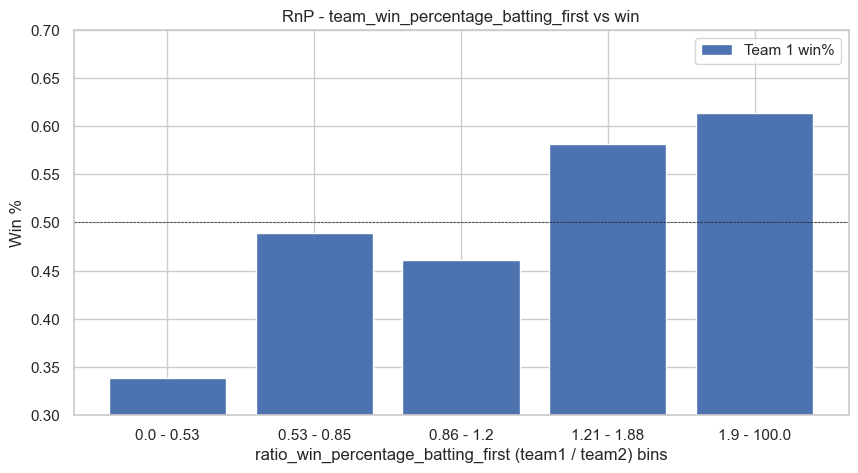

Correlation between team_win_percentage_batting_first and winner_01 is: -0.09853428612030792


In [153]:
createRnP(train_data, 'team_win_percentage_batting_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


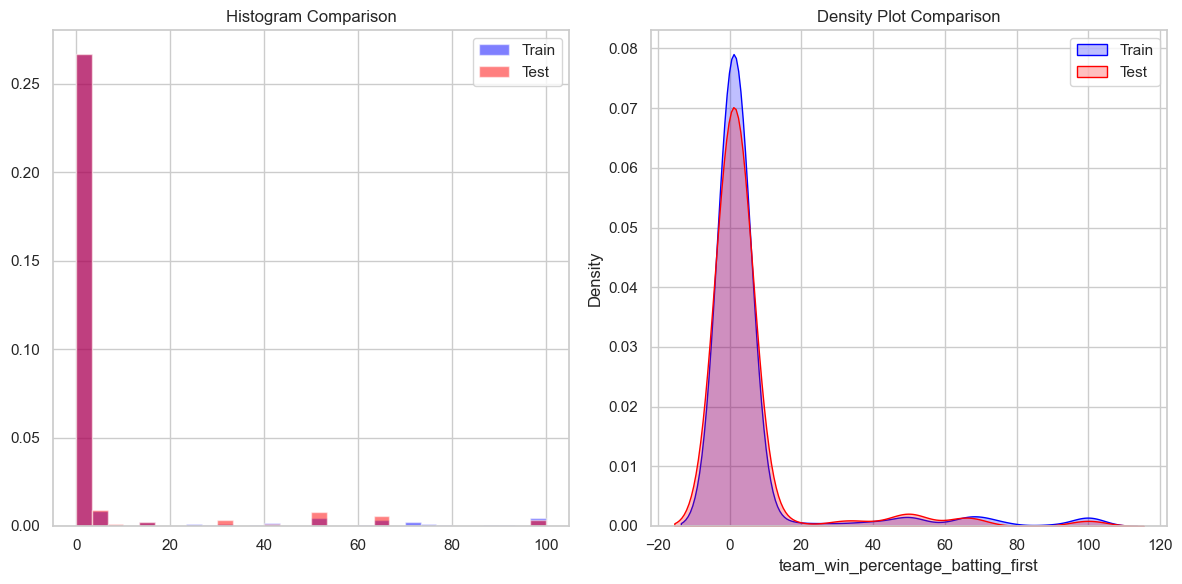

Kolmogorov-Smirnov test result: KS statistic = 0.0510, p-value = 0.6207

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.959401    5.299278
std      17.933664   15.812639
min       0.000000    0.000000
25%       0.604545    0.600000
50%       1.000000    1.000000
75%       1.609203    1.587500
max     100.000000  100.000000


In [154]:
check_distribution_match(train_data['team_win_percentage_batting_first'], test_data['team_win_percentage_batting_first'])

## Harshit More

slope: 0.6 / 0.31 =  1.92


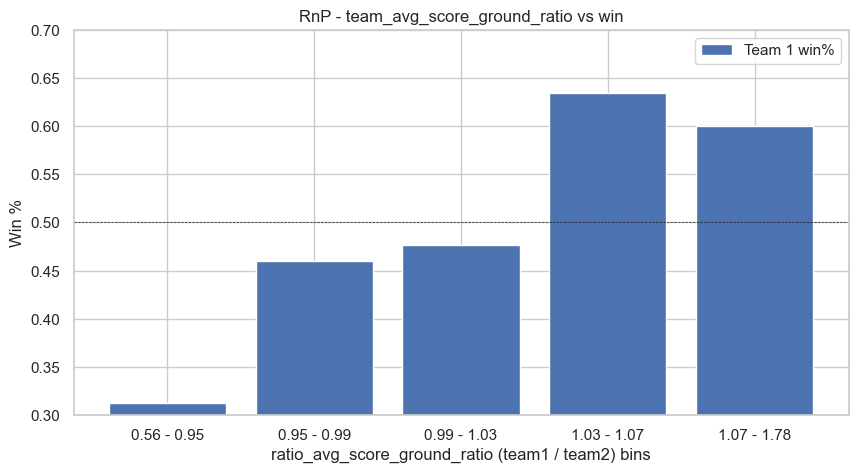

Correlation between team_avg_score_ground_ratio and winner_01 is: -0.2123613545271719


In [163]:
# Function to calculate ground's average score
def avg_score_at_ground(matches, ground_id):
    ground_matches = matches[matches['ground_id'] == ground_id]
    total_scores = ground_matches['inning1_runs'].sum() + ground_matches['inning2_runs'].sum()
    total_matches = len(ground_matches) * 2  # as each match has two innings
    return total_scores / total_matches if total_matches > 0 else 0

# Function to calculate team's average score
def avg_team_score(matches, team_id):
    team_matches = matches[(matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)]
    team_scores = team_matches.apply(lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1).sum()
    total_innings = len(team_matches) * 2  # as each match has two innings
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate ratio of team's avg score to ground's avg score
def team_to_ground_avg_score_ratio(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Apply to training data
train_data['team1_avg_score_ground_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
train_data['team2_avg_score_ground_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
train_data = add_ratio_column(train_data, 'team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio', 'team_avg_score_ground_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio'])

# Apply to test data
test_data['team1_avg_score_ground_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
test_data['team2_avg_score_ground_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
test_data = add_ratio_column(test_data, 'team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio', 'team_avg_score_ground_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio'])

createRnP(train_data, 'team_avg_score_ground_ratio')

slope: 0.63 / 0.33 =  1.92


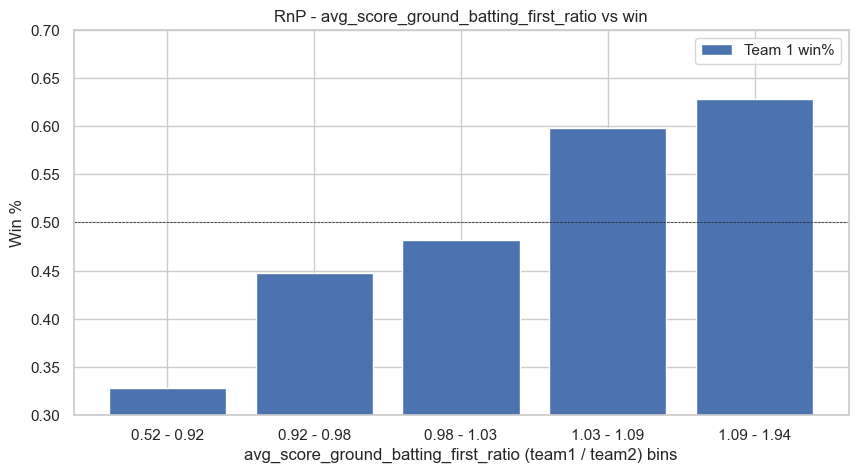

Correlation between avg_score_ground_batting_first_ratio and winner_01 is: -0.20373240248923474


In [164]:
def avg_score_at_ground(matches, ground_id):
    ground_matches = matches[matches['ground_id'] == ground_id]
    total_scores = ground_matches['inning1_runs'].sum() + ground_matches['inning2_runs'].sum()
    total_matches = len(ground_matches) * 2  # as each match has two innings
    return total_scores / total_matches if total_matches > 0 else 0

# Function to calculate team's average score
def avg_team_score(matches, team_id):
    team_matches = matches[(matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)]
    team_scores = team_matches.apply(lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1).sum()
    total_innings = len(team_matches) * 2  # as each match has two innings
    return team_scores / total_innings if total_innings > 0 else 0


# Function to calculate team's average score when batting first
def avg_team_score_batting_first(matches, team_id):
    team_matches = matches[matches['team1_id'] == team_id]
    team_scores = team_matches['inning1_runs'].sum()
    total_innings = len(team_matches)
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate team's average score when fielding first
def avg_team_score_fielding_first(matches, team_id):
    team_matches = matches[matches['team2_id'] == team_id]
    team_scores = team_matches['inning2_runs'].sum()
    total_innings = len(team_matches)
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate ratio of team's avg score to ground's avg score (batting first)
def team_to_ground_avg_score_ratio_batting_first(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score_batting_first(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Function to calculate ratio of team's avg score to ground's avg score (fielding first)
def team_to_ground_avg_score_ratio_fielding_first(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score_fielding_first(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Apply to training data
train_data['team1_avg_score_ground_batting_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
train_data['team2_avg_score_ground_batting_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
# train_data['team1_avg_score_ground_fielding_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
# train_data['team2_avg_score_ground_fielding_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio', 'avg_score_ground_batting_first_ratio')
# train_data = add_ratio_column(train_data, 'team1_avg_score_ground_fielding_first_ratio', 'team2_avg_score_ground_fielding_first_ratio', 'avg_score_ground_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio'])

# Apply to test data
test_data['team1_avg_score_ground_batting_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
test_data['team2_avg_score_ground_batting_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
# test_data['team1_avg_score_ground_fielding_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
# test_data['team2_avg_score_ground_fielding_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio', 'avg_score_ground_batting_first_ratio')
# test_data = add_ratio_column(test_data, 'team1_avg_score_ground_fielding_first_ratio', 'team2_avg_score_ground_fielding_first_ratio', 'avg_score_ground_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio'])

createRnP(train_data, 'avg_score_ground_batting_first_ratio')

slope: 0.62 / 0.32 =  1.96


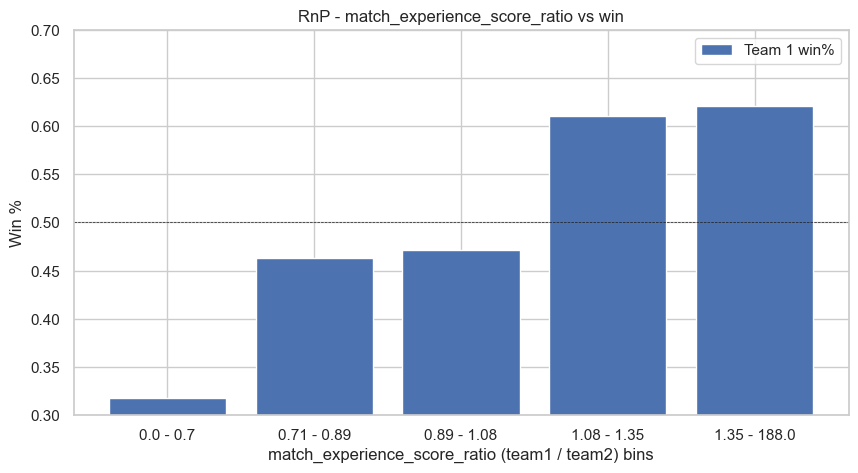

Correlation between match_experience_score_ratio and winner_01 is: -0.06841510458819834


In [165]:
# Function to calculate match experience score
def match_experience_score(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    total_experience_score = 0

    for player_id in team_ids:
        player_matches = matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(player_id)) | (matches['team2_roster_ids'].str.contains(player_id)))]
        total_experience_score += player_matches.shape[0]

    return total_experience_score

# Apply to training data
train_data['team1_match_experience_score'] = train_data.apply(lambda x: match_experience_score(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_match_experience_score'] = train_data.apply(lambda x: match_experience_score(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_match_experience_score', 'team2_match_experience_score', 'match_experience_score_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_match_experience_score', 'team2_match_experience_score'])

# Apply to test data
test_data['team1_match_experience_score'] = test_data.apply(lambda x: match_experience_score(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_match_experience_score'] = test_data.apply(lambda x: match_experience_score(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_match_experience_score', 'team2_match_experience_score', 'match_experience_score_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_match_experience_score', 'team2_match_experience_score'])

createRnP(train_data, 'match_experience_score_ratio')

## Selection

In [166]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_match_impact_score',
       'team_average_runs_per_match', 'team_balls_efficiency_score',
       'team_early_impact_score', 'team_boundary_efficiency_score',
       'team_team_average_powerplay_score', 'team_team_scoring_consistency',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'te

In [ ]:
cols = ['team_count_50runs_last15', 'team_match_impact_score',
       'team_average_runs_per_match', 'team_balls_efficiency_score',
       'team_early_impact_score', 'team_boundary_efficiency_score',
       'team_team_average_powerplay_score', 'team_team_scoring_consistency',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'team_momentum', 'team_batsman_performance_recent',
       'team_batsman_runs_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
       'team_avg_win_margin_runs', 'team_winp_venue', 'toss_winner_id',
       'bat_id', 'team_avg_runs_1st_inning', 'team_avg_eco',
       'consistency_index_ratio', 'avg_wickets_taken_batting_first_ratio',
       'avg_wickets_conceded_fielding_first_ratio', 'winner_01']

In [167]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_match_impact_score',
       'team_average_runs_per_match', 'team_balls_efficiency_score',
       'team_early_impact_score', 'team_boundary_efficiency_score',
       'team_team_average_powerplay_score', 'team_team_scoring_consistency',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'te

In [170]:
new_order = ['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_match_impact_score',
       'team_average_runs_per_match', 'team_balls_efficiency_score',
       'team_early_impact_score', 'team_boundary_efficiency_score',
       'team_team_average_powerplay_score', 'team_team_scoring_consistency',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'team_momentum', 'team_batsman_performance_recent',
       'team_batsman_runs_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
       'team_avg_win_margin_runs', 'team_winp_venue', 'toss_winner_id',
       'bat_id', 'team_avg_runs_1st_inning', 'team_avg_eco',
       'consistency_index_ratio', 'avg_wickets_taken_batting_first_ratio',
       'avg_wickets_conceded_fielding_first_ratio', 'team_win_rate_at_ground',
       'team_strike_rate', 'team_adjusted_win_rate_at_venue',
       'team_scoring_variance_at_venue', 'team_avg_partnership_length',
       'team_win_percentage_batting_first', 'team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio', 'winner_01']

In [172]:
df_new = train_data[new_order]

In [173]:
df_new.shape

(948, 66)

In [174]:
train_data.shape

(948, 66)

In [175]:
df_new.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,team_win_rate_at_ground,team_strike_rate,team_adjusted_win_rate_at_venue,team_scoring_variance_at_venue,team_avg_partnership_length,team_win_percentage_batting_first,team_avg_score_ground_ratio,avg_score_ground_batting_first_ratio,match_experience_score_ratio,winner_01
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,0.5,2.195160,0.5,NaN,0.758418,0.500000,0.999783,1.010862,1.774194,1
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,0.0,0.809549,0.0,NaN,0.877230,2.022222,1.021713,1.047372,1.419355,0
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,0.0,0.921047,0.0,NaN,0.766002,0.576923,1.032286,0.962517,0.491416,0
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,0.0,1.234011,0.0,NaN,1.730217,1.875000,1.028628,1.139912,0.823194,0
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,1.0,1.029057,1.0,NaN,0.912032,0.266667,0.956601,0.921507,0.833984,1


In [176]:
df_new.to_csv('combined_train_data.csv', index=False)

In [178]:
new_order = ['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids','toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_match_impact_score',
       'team_average_runs_per_match', 'team_balls_efficiency_score',
       'team_early_impact_score', 'team_boundary_efficiency_score',
       'team_team_average_powerplay_score', 'team_team_scoring_consistency',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_recent_form', 'team_momentum', 'team_batsman_performance_recent',
       'team_batsman_runs_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
       'team_avg_win_margin_runs', 'team_winp_venue', 'toss_winner_id',
       'bat_id', 'team_avg_runs_1st_inning', 'team_avg_eco',
       'consistency_index_ratio', 'avg_wickets_taken_batting_first_ratio',
       'avg_wickets_conceded_fielding_first_ratio', 'team_win_rate_at_ground',
       'team_strike_rate', 'team_adjusted_win_rate_at_venue',
       'team_scoring_variance_at_venue', 'team_avg_partnership_length',
       'team_win_percentage_batting_first', 'team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio', 'winner_01']

In [179]:
df_test = test_data[new_order[:-1]]

In [180]:
df_test.shape

(271, 63)

In [181]:
df_test.to_csv('combined_test_data.csv', index=False)